# ESG Portfolio Optimization and Backtesting

This notebook explores advanced portfolio optimization techniques with a focus on integrating Environmental, Social, and Governance (ESG) risk scores into the investment process. The workflow includes:

- **Data Preparation:** Loading and cleaning ESG scores and historical stock price data.
- **Return and Risk Calculation:** Computing log returns, annualized returns, and volatilities for each asset.
- **Portfolio Optimization:** 
    - Implementing multi-objective optimization using evolutionary algorithms (DEAP) to maximize return, minimize volatility, and minimize ESG risk.
    - Constructing efficient frontiers with and without ESG constraints.
    - Comparing different portfolio selection strategies (min variance, max return, min ESG, random).
- **Backtesting:** 
    - Simulating portfolio performance over time with periodic rebalancing.
    - Comparing portfolio values against a benchmark index (XLI).
- **Performance Evaluation:** 
    - Calculating key metrics such as alpha, beta, Sharpe ratio, and maximum drawdown.
    - Visualizing results with 2D and 3D plots to illustrate the risk-return-ESG trade-offs.

This notebook provides a comprehensive framework for ESG-aware portfolio construction, optimization, and performance analysis, enabling users to assess the impact of ESG integration on investment outcomes.

In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv
import yfinance as yf
import os 
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy.stats import linregress
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from deap import base, creator, tools, algorithms
import warnings
import multiprocessing
import time
import plotly.graph_objects as go

In [807]:
esg_df = pd.read_csv(r"C:\Users\bjorn\FE 800\ESG Data.csv", index_col = 0)
esg_clean_df = esg_df.loc[:, esg_df.loc[2024] != 0]
esg_two_pts_df = esg_clean_df.loc[:,esg_clean_df.loc[2023] != 0]

In [809]:
esg_clean_df

GE   CAT   RTX  UBER   ETN   UNP   HON   ADP   LMT    BA  ...  NDSN  \
Year                                                              ...         
2023  40.7  34.2   0.0   0.0  17.9  25.2  28.6  14.0  28.4  39.6  ...  26.7   
2024  32.7  28.3  29.6  20.4  21.0  20.0  27.1  15.1  28.1  36.5  ...  24.1   

       ROL   SWK  CHRW   DAY  ALLE  GNRC  PAYC   AOS   HII  
Year                                                        
2023  19.9  25.9  20.0   0.0  24.0   0.0   0.0  25.5   0.0  
2024  18.6  26.2  17.4  17.3  19.8  21.9  18.9  26.8  34.2  

[2 rows x 75 columns]

In [811]:
current_esg_risk_scores = esg_clean_df.loc[2024]
current_esg_risk_scores

GE      32.7
CAT     28.3
RTX     29.6
UBER    20.4
ETN     21.0
        ... 
ALLE    19.8
GNRC    21.9
PAYC    18.9
AOS     26.8
HII     34.2
Name: 2024, Length: 75, dtype: float64

In [813]:
esg_two_pts_df

GE   CAT   ETN   UNP   HON   ADP   LMT    BA    DE   UPS  ...   IEX  \
Year                                                              ...         
2023  40.7  34.2  17.9  25.2  28.6  14.0  28.4  39.6  16.7  19.6  ...  29.3   
2024  32.7  28.3  21.0  20.0  27.1  15.1  28.1  36.5  16.3  18.8  ...  30.6   

      EXPD   TXT  JBHT  NDSN   ROL   SWK  CHRW  ALLE   AOS  
Year                                                        
2023  15.7  34.4  14.3  26.7  19.9  25.9  20.0  24.0  25.5  
2024  16.2  33.8  14.3  24.1  18.6  26.2  17.4  19.8  26.8  

[2 rows x 61 columns]

In [815]:
warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
tickers = []
for col in esg_clean_df.columns:
    tickers.append(col)
    stock_prices = pd.DataFrame(columns = tickers)
df_tick =  yf.download(tickers,start = '2023-1-1', end = '2024-11-12')['Adj Close']
for ticker in tickers:
    stock_prices[ticker] = df_tick[ticker]


[*********************100%***********************]  75 of 75 completed


In [817]:
common_columns = esg_clean_df.columns.intersection(stock_prices.columns)
stock_prices = stock_prices[common_columns]

In [819]:
stock_prices.head()

GE         CAT        RTX       UBER  \
Date                                                                     
2023-01-03 00:00:00+00:00  52.524132  230.392593  95.977661  25.360001   
2023-01-04 00:00:00+00:00  55.581261  232.784500  96.006226  25.910000   
2023-01-05 00:00:00+00:00  56.444279  231.742859  96.044312  25.549999   
2023-01-06 00:00:00+00:00  56.958923  240.018005  97.548576  26.400000   
2023-01-09 00:00:00+00:00  57.536903  237.857574  94.825668  27.400000   

                                  ETN         UNP         HON         ADP  \
Date                                                                        
2023-01-03 00:00:00+00:00  153.045151  199.231796  205.286545  228.564484   
2023-01-04 00:00:00+00:00  154.083237  200.825043  201.205734  229.641617   
2023-01-05 00:00:00+00:00  152.511536  194.912781  195.869980  224.688705   
2023-01-06 00:00:00+00:00  156.295227  203.483643  201.426041  230.968796   
2023-01-09 00:00:00+00:00  156.081787  202.955780  201.809219  230.343643   

                                  LMT          BA  ...        NDSN        ROL  \
Date                                               ...                          
2023-01-03 00:00:00+00:00  453.063049  195.389999  ...  233.451675  35.568249   
2023-01-04 00:00:00+00:00  452.085846  203.639999  ...  233.177032  35.947769   
2023-01-05 00:00:00+00:00  452.626648  204.990005  ...  225.321106  35.334690   
2023-01-06 00:00:00+00:00  448.992859  213.000000  ...  231.235153  35.548786   
2023-01-09 00:00:00+00:00  435.472961  208.570007  ...  236.599899  35.548786   

                                 SWK       CHRW        DAY        ALLE  \
Date                                                                     
2023-01-03 00:00:00+00:00  70.833763  86.058113  61.570000  104.817329   
2023-01-04 00:00:00+00:00  73.074318  86.553802  63.060001  106.316101   
2023-01-05 00:00:00+00:00  73.111519  85.800743  59.820000  104.865982   
2023-01-06 00:00:00+00:00  75.370689  88.946404  60.959999  108.437744   
2023-01-09 00:00:00+00:00  76.384064  88.994080  62.880001  109.264992   

                                 GNRC        PAYC        AOS         HII  
Date                                                                      
2023-01-03 00:00:00+00:00   97.709999  300.720062  56.935123  218.521637  
2023-01-04 00:00:00+00:00  101.919998  299.999390  58.616512  218.339783  
2023-01-05 00:00:00+00:00   98.269997  290.838501  57.379631  217.181870  
2023-01-06 00:00:00+00:00  100.750000  282.970795  59.370232  220.205872  
2023-01-09 00:00:00+00:00  104.739998  288.834564  59.418549  212.023880  

[5 rows x 75 columns]

In [820]:
returns_df = np.log(stock_prices/stock_prices.shift(1))

In [823]:
annualized_ret = returns_df.mean()*252
annualized_vol = returns_df.std()*np.sqrt(252)

In [825]:
annualized_ret

GE      0.678135
CAT     0.293006
RTX     0.137796
UBER    0.560454
ETN     0.479192
          ...   
ALLE    0.169238
GNRC    0.373176
PAYC   -0.150974
AOS     0.149424
HII    -0.033861
Length: 75, dtype: float64

In [827]:
annualized_vol

GE      0.273924
CAT     0.277305
RTX     0.212359
UBER    0.376888
ETN     0.276374
          ...   
ALLE    0.237826
GNRC    0.481832
PAYC    0.522411
AOS     0.262466
HII     0.317148
Length: 75, dtype: float64

In [828]:
#compare weighted portfolio ESG score, mess around with the weights of the different objectives, show the ESG frontier
# changing too much? clips 

In [832]:
cov_matrix = returns_df.cov() * 252  # Precompute once

def portfolio_performance(weights):
    portfolio_return = np.dot(weights, annualized_ret)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    portfolio_esg_score = np.dot(weights, current_esg_risk_scores)
    return -portfolio_return, portfolio_volatility, portfolio_esg_score

In [834]:
def evaluate_all(population):
    weights = np.array([np.clip(ind, 0, 1) for ind in population])
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights_sum[weights_sum == 0] = 1  # Prevent division by zero
    weights = weights / weights_sum

    # Update normalized weights back to the individuals
    for ind, normalized_weights in zip(population, weights):
        for i in range(len(ind)):
            ind[i] = normalized_weights[i]

    # Calculate portfolio returns, volatility, and ESG scores for all individuals
    portfolio_returns = np.dot(weights, annualized_ret)
    portfolio_volatilities = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov_matrix, weights))
    portfolio_esg_scores = np.dot(weights, current_esg_risk_scores)

    # Combine results into a list of tuples (fitness values for DEAP)
    fitness_values = list(zip(-portfolio_returns, portfolio_volatilities, portfolio_esg_scores))

    return fitness_values

def evaluate(individual):
    # Normalize weights so they sum to 1
    weights = np.clip(individual, 0, 1)
    
    weights_sum = np.sum(weights)
    if weights_sum > 0:
        weights /= weights_sum

    # Assign normalized weights back to the individual
    for i in range(len(individual)):
        individual[i] = weights[i]

    # Calculate fitness values
    return portfolio_performance(weights)

In [836]:
if "FitnessMulti" in creator.__dict__:
    del creator.FitnessMulti
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)  # Random weights between 0 and 1
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(annualized_ret))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("evaluate", evaluate)  # Register the evaluation function
toolbox.register("mate", tools.cxBlend, alpha=0.3)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=1, indpb=0.4)
toolbox.register("select", tools.selNSGA2)

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

initial_min_return_dist = 0.05
initial_min_volatility_dist = 0.05
initial_min_esg_dist = 0.5

final_min_return_dist = 0.025
final_min_volatility_dist = 0.025
final_min_esg_dist = 0.25

def get_min_distances(gen, max_gen):
    factor = 1 - (gen / max_gen)
    return (
        initial_min_return_dist * factor + final_min_return_dist * (1 - factor),
        initial_min_volatility_dist * factor + final_min_volatility_dist * (1 - factor),
        initial_min_esg_dist * factor + final_min_esg_dist * (1 - factor)
    )
    
def is_far_enough_vectorized(population, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    if not hof:
        return [True] * len(population)
    hof_values = np.array([ind.fitness.values for ind in hof])
    pop_values = np.array([ind.fitness.values for ind in population])
    distances = np.abs(pop_values[:, None, :] - hof_values[None, :, :])  # Pairwise distances
    far_enough = np.all(
        (distances[..., 0] >= min_return_dist) | 
        (distances[..., 1] >= min_volatility_dist) | 
        (distances[..., 2] >= min_esg_dist),
        axis=-1
    )
    return far_enough

def is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    """
    Check if a single individual is far enough from all individuals in the Hall of Fame (HoF).
    """
    if not hof:  # If the Hall of Fame is empty, consider it far enough
        return True

    ind_fitness = ind.fitness.values  # Fitness of the individual being checked
    for hof_ind in hof:
        hof_fitness = hof_ind.fitness.values
        # Check distances for each metric
        if (
            abs(ind_fitness[0] - hof_fitness[0]) < min_return_dist or
            abs(ind_fitness[1] - hof_fitness[1]) < min_volatility_dist or
            abs(ind_fitness[2] - hof_fitness[2]) < min_esg_dist
        ):
            return False  # Too close to an existing HoF individual
    return True  # Far enough
    
def select_with_distance_backup(population, min_return_dist, min_volatility_dist, min_esg_dist, k, hof=None):
    selected = []
    for ind in population:
        if len(selected) >= k:
            break
        if is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
            selected.append(ind)
    if len(selected) < k:
        remaining_spots = k - len(selected)
        additional_individuals = [ind for ind in population if ind not in selected][:remaining_spots]
        selected.extend(additional_individuals)
    return selected

def recompute_fitness(population):
    # Identify individuals with invalid or empty fitness
    invalid_individuals = [ind for ind in population if not ind.fitness.valid or ind.fitness.values == ()]
    
    if invalid_individuals:
        print(f"Recomputing fitness for {len(invalid_individuals)} individuals...")
        # Use evaluate_all for batch fitness computation
        invalid_fitness = evaluate_all(invalid_individuals)
        
        # Assign the computed fitness values back to the individuals
        for fit, ind in zip(invalid_fitness, invalid_individuals):
            ind.fitness.values = fit

def normalize_population(population):
    """
    Normalize the weights of all individuals in the population so that they sum to 1.
    :param population: List of individuals (portfolios).
    """
    for ind in population:
        weights = np.clip(np.array(ind), 0, 1)  # Clip weights to [0, 1]
        weights_sum = np.sum(weights)
        if weights_sum > 0:
            normalized_weights = weights / weights_sum
        else:
            normalized_weights = weights  # Prevent division by zero
        ind[:] = normalized_weights  # Update the individual in-place


toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=20000, 
    hof=None  # Ensure this is passed dynamically
)

def initialize_extreme_population():
    # Add individuals with extreme weights (e.g., max allocation to one asset)
    extremes = []
    for i in range(len(annualized_ret)):
        weights = np.zeros(len(annualized_ret))
        weights[i] = 1.0
        extremes.append(creator.Individual(weights.tolist()))
    return extremes


population = toolbox.population(n=10000) + initialize_extreme_population()
hof = tools.HallOfFame(15000)
num_generations = 50

for gen in range(num_generations):
    start_time = time.time()
    print(f"Generation {gen} started...")
    
    # Generate offspring
    offspring = algorithms.varOr(population, toolbox, lambda_=20000, cxpb=0.75, mutpb=0.05)
    print(f"Generated {len(offspring)} offspring.")

    normalize_population(population)
    normalize_population(offspring)
    
    # Evaluate fitness
    fits = evaluate_all(offspring)
    #fits = toolbox.map(toolbox.evaluate, offspring)
    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, offspring):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")
    
    
    combined = population + offspring
   
    # Calculate generation-specific distances
    min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
    print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")

    for ind in combined:
        if not hasattr(ind, "fitness"):
            raise ValueError(f"Individual {ind} is missing the fitness attribute!")

    recompute_fitness(combined)
    
    population = [ind for ind in population if isinstance(ind, creator.Individual)]
 
    # Apply distance-based selection
    population = toolbox.select_with_distance(
    combined, 
    min_return_dist=min_return_dist, 
    min_volatility_dist=min_volatility_dist, 
    min_esg_dist=min_esg_dist, 
    k=7500, 
    hof=hof  # Pass dynamically here
    )
    
    print(f"Selected next generation population of size {len(population)}.")

    fits = evaluate_all(population)
    #fits = toolbox.map(toolbox.evaluate, offspring)

    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, population):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")

    
    hof.update(population)
    print(f"Updated Hall of Fame with {len(hof)} solutions.")
    
    elapsed_time = time.time() - start_time
    print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

print("Evolution completed!")

# Extract Pareto front and weights
pareto_front = np.array([ind.fitness.values for ind in hof])
pareto_weights = np.array([list(ind) for ind in hof])

# Display results
print("Pareto Front:")
print(pareto_front)
print("Pareto Weights:")
print(pareto_weights)

# Close multiprocessing pool
pool.close()
pool.join()

Generation 0 started...
Generated 20000 offspring.
Generation 0 - Distance thresholds: 0.05, 0.05, 0.5
Recomputing fitness for 6764 individuals...
Selected next generation population of size 7500.
Updated Hall of Fame with 7500 solutions.
Generation 0 completed in 8.59 seconds.
Generation 1 started...
Generated 20000 offspring.
Generation 1 - Distance thresholds: 0.0495, 0.0495, 0.495
Selected next generation population of size 7500.
Updated Hall of Fame with 8522 solutions.
Generation 1 completed in 12.67 seconds.
Generation 2 started...
Generated 20000 offspring.
Generation 2 - Distance thresholds: 0.049, 0.049, 0.49
Selected next generation population of size 7500.
Updated Hall of Fame with 9042 solutions.
Generation 2 completed in 12.05 seconds.
Generation 3 started...
Generated 20000 offspring.
Generation 3 - Distance thresholds: 0.0485, 0.0485, 0.485
Selected next generation population of size 7500.
Updated Hall of Fame with 9343 solutions.
Generation 3 completed in 12.01 seconds

In [837]:
pareto_front[:,0] = -pareto_front[:,0]
returns = pareto_front[:,0]

In [838]:
returns

array([0.19091822, 0.19091822, 0.19476431, ..., 0.32260439, 0.37034591,
       0.37034591])

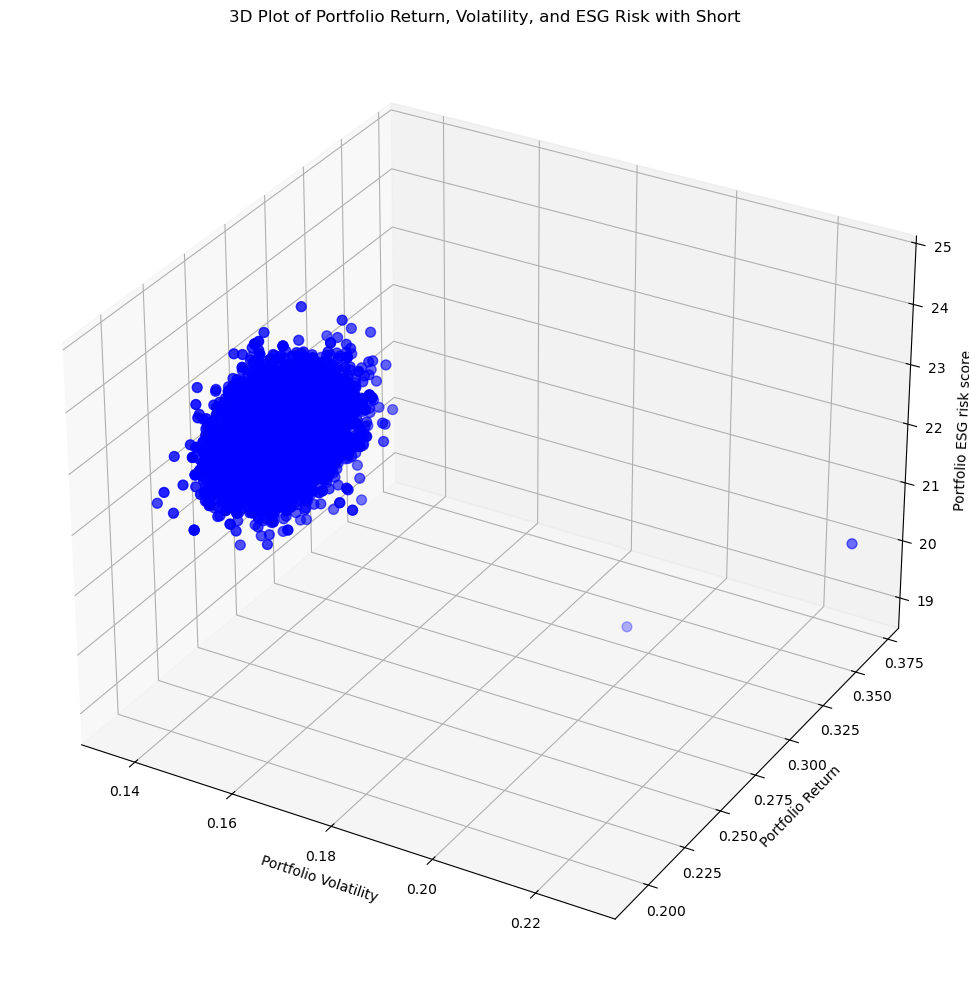

In [839]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pareto_front[:,1], pareto_front[:,0], pareto_front[:,2], color='blue', s=50)

ax.set_xlabel('Portfolio Volatility')
ax.set_zlabel('Portfolio ESG risk score')
ax.set_ylabel('Portfolio Return')

# Set title
ax.set_title('3D Plot of Portfolio Return, Volatility, and ESG Risk with Short')
plt.tight_layout()
# Show the plot
plt.show()

In [840]:
%matplotlib widget

grid_x, grid_y = np.mgrid[
    volatility.min():volatility.max():100j, 
    returns.min():returns.max():100j
]
grid_z = griddata(
    (volatility, returns), esg_risk, (grid_x, grid_y), method='cubic'
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none', alpha=0.8
)

ax.set_xlabel("Portfolio Volatility")
ax.set_ylabel("Portfolio Return")
ax.set_zlabel("Portfolio ESG Risk Score")
ax.set_title("Interactive 3D Surface Plot of Portfolio Metrics")
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

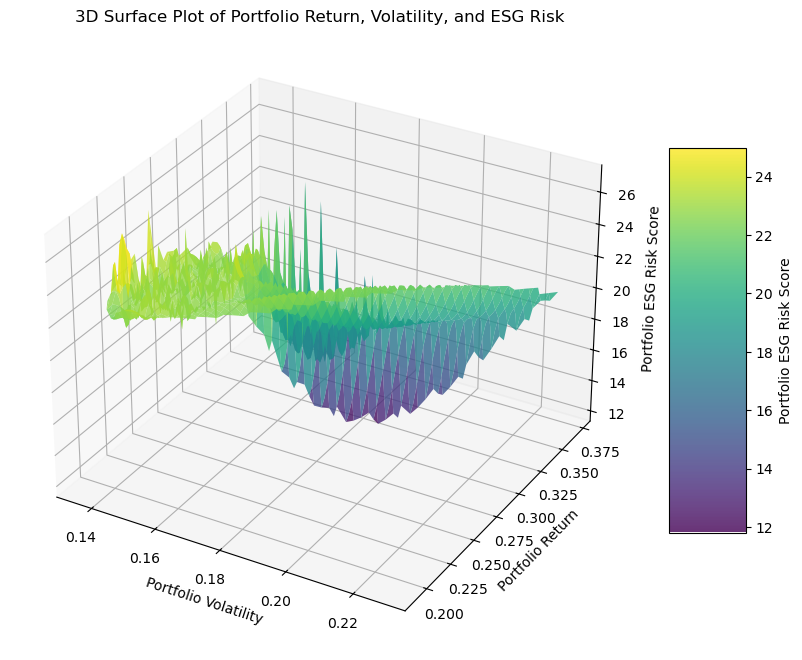

In [868]:
%matplotlib inline
volatility = pareto_front[:, 1]
returns = pareto_front[:, 0]
esg_risk = pareto_front[:, 2]

# Create a grid of points
grid_x, grid_y = np.mgrid[
    volatility.min():volatility.max():100j, 
    returns.min():returns.max():100j
]

# Interpolate ESG risk values onto the grid based on (volatility, return) pairs
grid_z = griddata(
    (volatility, returns), esg_risk, (grid_x, grid_y), method='cubic'
)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, cmap='viridis', edgecolor='none', alpha=0.8
)

# Add color bar to represent ESG Risk levels
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Portfolio ESG Risk Score')

# Set labels and title
ax.set_xlabel("Portfolio Volatility")
ax.set_ylabel("Portfolio Return")
ax.set_zlabel("Portfolio ESG Risk Score")
ax.set_title("3D Surface Plot of Portfolio Return, Volatility, and ESG Risk")

plt.show()

In [870]:

# Assuming pareto_front, volatility, returns, esg_risk are already defined
volatility = pareto_front[:, 1]
returns = pareto_front[:, 0]
esg_risk = pareto_front[:, 2]

# Create a grid of points
grid_x, grid_y = np.mgrid[
    volatility.min():volatility.max():100j,
    returns.min():returns.max():100j
]

# Interpolate ESG risk values onto the grid
grid_z = griddata(
    (volatility, returns), esg_risk, (grid_x, grid_y), method='cubic'
)

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=grid_z, y=grid_x, z=grid_y, colorscale='Viridis', colorbar=dict(title='ESG Risk')
)])

fig.update_layout(
    width =1200, height =800,
    scene=dict(
        yaxis_title='Portfolio Volatility',
        zaxis_title='Portfolio Return',
        xaxis_title='Portfolio ESG Risk Score',
    ),
    title='Interactive 3D ESG Frontier',
)

fig.show()


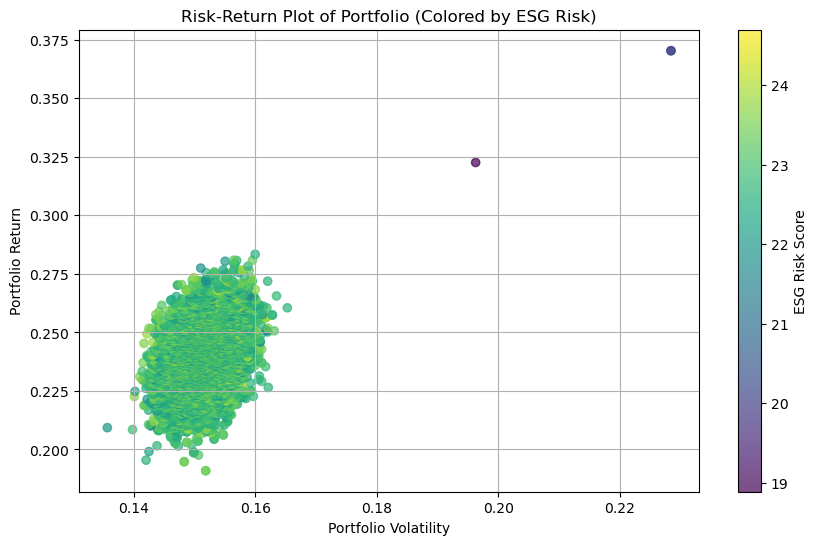

In [872]:
volatility = pareto_front[:, 1]  # Assuming volatility is in the second column
returns = pareto_front[:, 0] 
esg_risk = pareto_front[:, 2]  # Assuming ESG Risk is in the first column

plt.figure(figsize=(10, 6))
sc = plt.scatter(volatility, returns, c=esg_risk, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="ESG Risk Score")  # Add color bar to show ESG Risk

# Add labels and title
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Return")
plt.title("Risk-Return Plot of Portfolio (Colored by ESG Risk)")

plt.grid(True)
plt.show()


In [873]:
def covariance_matrix(log_rets):
    x = (log_rets).cov()*252
    return x.values

def compute_metrics(log_rets, tickers):
    means = []
    vols = []
    
    # Calculate the mean and volatility (standard deviation) for each ticker
    for i in tickers:
        mean = log_rets[i].mean()*252
        vol = log_rets[i].std()*np.sqrt(252)
        means.append(mean)
        vols.append(vol)
    
    # Create a DataFrame to hold the metrics
    metrics_df = pd.DataFrame({
        'Annualized Mean': means,
        'Annualized Volatility': vols
    }, index=tickers)
    
    return metrics_df

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def optimize_portfolio_long_only(cov_matrix, expected_returns, target_return):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result


In [875]:
expected_returns = compute_metrics(returns_df, tickers)["Annualized Mean"].values
stock_vols = compute_metrics(returns_df, tickers)["Annualized Volatility"].values

In [878]:
cov_mat = covariance_matrix(returns_df)
cov_mat

array([[ 0.0750344 ,  0.02788922,  0.00822908, ...,  0.02911713,
         0.01845729,  0.01635416],
       [ 0.02788922,  0.07689793,  0.01369633, ...,  0.02623608,
         0.03190939,  0.02297208],
       [ 0.00822908,  0.01369633,  0.04509644, ...,  0.01075786,
         0.00974642,  0.0179556 ],
       ...,
       [ 0.02911713,  0.02623608,  0.01075786, ...,  0.27291355,
         0.02016179, -0.00821075],
       [ 0.01845729,  0.03190939,  0.00974642, ...,  0.02016179,
         0.06888843,  0.01868173],
       [ 0.01635416,  0.02297208,  0.0179556 , ..., -0.00821075,
         0.01868173,  0.10058271]])

In [880]:
target_returns = np.arange(0,max(annualized_ret),.01)
port_rets_lo = []
port_vols_lo = []
port_noesgs_lo = []
for tar_ret in target_returns:
    optimized_result = optimize_portfolio_long_only(cov_mat, expected_returns, tar_ret)
    port_return = tar_ret
    port_vol = np.sqrt(optimized_result.fun)
    port_esg = np.dot(optimized_result.x, current_esg_risk_scores)
    port_rets_lo.append(port_return)
    port_vols_lo.append(port_vol)
    port_noesgs_lo.append(port_esg)

In [881]:
def minvar_portfolio_long_only_ESG(cov_matrix, esg_risk_scores, esg_target):
    num_assets = cov_matrix.shape[0]

    init_weights = np.ones(num_assets) / num_assets

    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights
        
        {'type': 'eq', 'fun': lambda weights: esg_target - np.dot(weights, esg_risk_scores)}  # Max ESG constraint
    )
    
    
    # Bounds: Weights between 0 and 1 (optional, no shorting)
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(portfolio_variance, init_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [882]:
esg_targets = np.arange(min(current_esg_risk_scores),max(current_esg_risk_scores),.1)
port_rets_esg_lo = []
port_vols_esg_lo = []
port_esgs_lo = []
for esg_tar in esg_targets:
    optimized_result = minvar_portfolio_long_only_ESG(cov_mat, current_esg_risk_scores, esg_tar)
    port_esg = np.dot(optimized_result.x, current_esg_risk_scores)
    port_return = np.dot(optimized_result.x, annualized_ret)
    port_vol = np.sqrt(optimized_result.fun)
    port_rets_esg_lo.append(port_return)
    port_vols_esg_lo.append(port_vol)
    port_esgs_lo.append(port_esg)

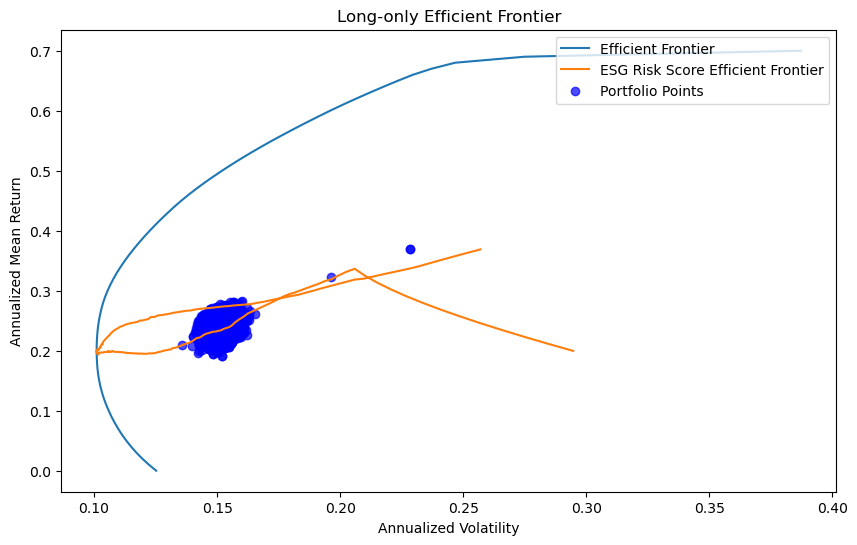

In [883]:
plt.figure(figsize=(10, 6))

plt.plot(port_vols_lo, port_rets_lo, label = 'Efficient Frontier')
plt.plot(port_vols_esg_lo, port_rets_esg_lo,label = 'ESG Risk Score Efficient Frontier')
plt.scatter(volatility, returns, c='blue', alpha=0.7, label="Portfolio Points")
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Mean Return')
plt.title('Long-only Efficient Frontier')
plt.legend(loc= 'upper right')
plt.show()

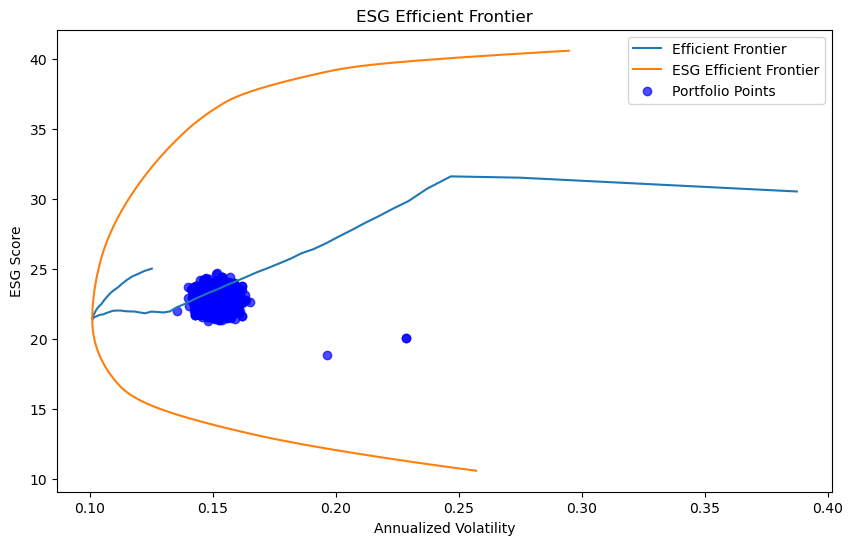

In [884]:
plt.figure(figsize=(10, 6))

plt.plot(port_vols_lo, port_noesgs_lo, label = 'Efficient Frontier')
plt.plot(port_vols_esg_lo, port_esgs_lo, label = 'ESG Efficient Frontier')
plt.scatter(volatility, esg_risk, c='blue', alpha=0.7, label="Portfolio Points")
plt.xlabel('Annualized Volatility')
plt.ylabel('ESG Score')
plt.title('ESG Efficient Frontier')
plt.legend()
plt.show()

In [886]:
if "FitnessMulti" in creator.__dict__:
    del creator.FitnessMulti
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)  # Random weights between 0 and 1
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(annualized_ret))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("evaluate", evaluate)  # Register the evaluation function
toolbox.register("mate", tools.cxBlend, alpha=0.3)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=1, indpb=0.4)
toolbox.register("select", tools.selNSGA2)

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

initial_min_return_dist = 0.05
initial_min_volatility_dist = 0.05
initial_min_esg_dist = 0.5

final_min_return_dist = 0.025
final_min_volatility_dist = 0.025
final_min_esg_dist = 0.25

def get_min_distances(gen, max_gen):
    factor = 1 - (gen / max_gen)
    return (
        initial_min_return_dist * factor + final_min_return_dist * (1 - factor),
        initial_min_volatility_dist * factor + final_min_volatility_dist * (1 - factor),
        initial_min_esg_dist * factor + final_min_esg_dist * (1 - factor)
    )
    
def is_far_enough_vectorized(population, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    if not hof:
        return [True] * len(population)
    hof_values = np.array([ind.fitness.values for ind in hof])
    pop_values = np.array([ind.fitness.values for ind in population])
    distances = np.abs(pop_values[:, None, :] - hof_values[None, :, :])  # Pairwise distances
    far_enough = np.all(
        (distances[..., 0] >= min_return_dist) | 
        (distances[..., 1] >= min_volatility_dist) | 
        (distances[..., 2] >= min_esg_dist),
        axis=-1
    )
    return far_enough

def is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    """
    Check if a single individual is far enough from all individuals in the Hall of Fame (HoF).
    """
    if not hof:  # If the Hall of Fame is empty, consider it far enough
        return True

    ind_fitness = ind.fitness.values  # Fitness of the individual being checked
    for hof_ind in hof:
        hof_fitness = hof_ind.fitness.values
        # Check distances for each metric
        if (
            abs(ind_fitness[0] - hof_fitness[0]) < min_return_dist or
            abs(ind_fitness[1] - hof_fitness[1]) < min_volatility_dist or
            abs(ind_fitness[2] - hof_fitness[2]) < min_esg_dist
        ):
            return False  # Too close to an existing HoF individual
    return True  # Far enough
    
def select_with_distance_backup(population, min_return_dist, min_volatility_dist, min_esg_dist, k, hof=None):
    selected = []
    for ind in population:
        if len(selected) >= k:
            break
        if is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
            selected.append(ind)
    if len(selected) < k:
        remaining_spots = k - len(selected)
        additional_individuals = [ind for ind in population if ind not in selected][:remaining_spots]
        selected.extend(additional_individuals)
    return selected

def recompute_fitness(population):
    # Identify individuals with invalid or empty fitness
    invalid_individuals = [ind for ind in population if not ind.fitness.valid or ind.fitness.values == ()]
    
    if invalid_individuals:
        print(f"Recomputing fitness for {len(invalid_individuals)} individuals...")
        # Use evaluate_all for batch fitness computation
        invalid_fitness = evaluate_all(invalid_individuals)
        
        # Assign the computed fitness values back to the individuals
        for fit, ind in zip(invalid_fitness, invalid_individuals):
            ind.fitness.values = fit

def normalize_population(population):
    """
    Normalize the weights of all individuals in the population so that they sum to 1.
    :param population: List of individuals (portfolios).
    """
    for ind in population:
        weights = np.clip(np.array(ind), 0, 1)  # Clip weights to [0, 1]
        weights_sum = np.sum(weights)
        if weights_sum > 0:
            normalized_weights = weights / weights_sum
        else:
            normalized_weights = weights  # Prevent division by zero
        ind[:] = normalized_weights  # Update the individual in-place


toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=20000, 
    hof=None  # Ensure this is passed dynamically
)

def initialize_extreme_population():
    # Add individuals with extreme weights (e.g., max allocation to one asset)
    extremes = []
    for i in range(len(annualized_ret)):
        weights = np.zeros(len(annualized_ret))
        weights[i] = 1.0
        extremes.append(creator.Individual(weights.tolist()))
    return extremes


population = toolbox.population(n=10000) + initialize_extreme_population()
hof = tools.HallOfFame(15000)
num_generations = 30

for gen in range(num_generations):
    start_time = time.time()
    print(f"Generation {gen} started...")
    
    # Generate offspring
    offspring = algorithms.varOr(population, toolbox, lambda_=20000, cxpb=0.75, mutpb=0.1)
    print(f"Generated {len(offspring)} offspring.")

    normalize_population(population)
    normalize_population(offspring)
    
    # Evaluate fitness
    fits = evaluate_all(offspring)
    #fits = toolbox.map(toolbox.evaluate, offspring)
    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, offspring):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")
    
    
    combined = population + offspring
   
    # Calculate generation-specific distances
    min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
    print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")

    for ind in combined:
        if not hasattr(ind, "fitness"):
            raise ValueError(f"Individual {ind} is missing the fitness attribute!")

    recompute_fitness(combined)
    
    population = [ind for ind in population if isinstance(ind, creator.Individual)]
 
    # Apply distance-based selection
    population = toolbox.select_with_distance(
    combined, 
    min_return_dist=min_return_dist, 
    min_volatility_dist=min_volatility_dist, 
    min_esg_dist=min_esg_dist, 
    k=5000, 
    hof=hof  # Pass dynamically here
    )
    
    print(f"Selected next generation population of size {len(population)}.")

    fits = evaluate_all(population)
    #fits = toolbox.map(toolbox.evaluate, offspring)

    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, population):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")

    
    hof.update(population)
    print(f"Updated Hall of Fame with {len(hof)} solutions.")
    
    elapsed_time = time.time() - start_time
    print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

print("Evolution completed!")

# Extract Pareto front and weights
pareto_front_1 = np.array([ind.fitness.values for ind in hof])
pareto_weights_1 = np.array([list(ind) for ind in hof])

# Display results
print("Pareto Front:")
print(pareto_front_1)
print("Pareto Weights:")
print(pareto_weights_1)

# Close multiprocessing pool
pool.close()
pool.join()

Generation 0 started...
Generated 20000 offspring.
Generation 0 - Distance thresholds: 0.05, 0.05, 0.5
Recomputing fitness for 7452 individuals...
Selected next generation population of size 5000.
Updated Hall of Fame with 5000 solutions.
Generation 0 completed in 5.79 seconds.
Generation 1 started...
Generated 20000 offspring.
Generation 1 - Distance thresholds: 0.04916666666666667, 0.04916666666666667, 0.4916666666666667
Selected next generation population of size 5000.
Updated Hall of Fame with 5753 solutions.
Generation 1 completed in 8.35 seconds.
Generation 2 started...
Generated 20000 offspring.
Generation 2 - Distance thresholds: 0.04833333333333333, 0.04833333333333333, 0.48333333333333334
Selected next generation population of size 5000.
Updated Hall of Fame with 6132 solutions.
Generation 2 completed in 8.11 seconds.
Generation 3 started...
Generated 20000 offspring.
Generation 3 - Distance thresholds: 0.04750000000000001, 0.04750000000000001, 0.475
Selected next generation 

In [887]:
pareto_front_1[:,0] = -pareto_front_1[:,0]
returns = pareto_front_1[:,0]
returns

array([0.12546701, 0.19215762, 0.19349148, ..., 0.27900887, 0.28484268,
       0.34303398])

In [888]:

# Assuming pareto_front, volatility, returns, esg_risk are already defined
volatility = pareto_front_1[:, 1]
returns = pareto_front_1[:, 0]
esg_risk = pareto_front_1[:, 2]

# Create a grid of points
grid_x, grid_y = np.mgrid[
    volatility.min():volatility.max():100j,
    returns.min():returns.max():100j
]

# Interpolate ESG risk values onto the grid
grid_z = griddata(
    (volatility, returns), esg_risk, (grid_x, grid_y), method='cubic'
)

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=grid_z, y=grid_x, z=grid_y, colorscale='Viridis', colorbar=dict(title='ESG Risk')
)])

fig.update_layout(
    width =1200, height =800,
    scene=dict(
        yaxis_title='Portfolio Volatility',
        zaxis_title='Portfolio Return',
        xaxis_title='Portfolio ESG Risk Score',
    ),
    title='Interactive 3D ESG Frontier',
)

fig.show()


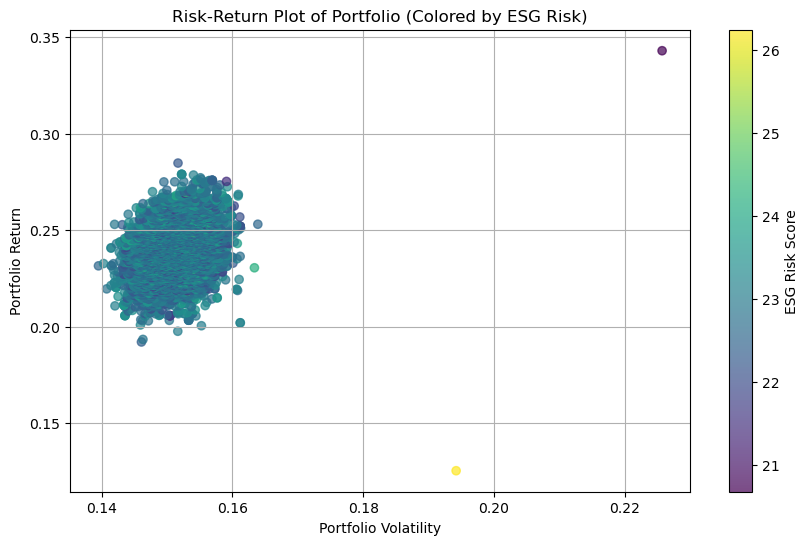

In [889]:
volatility = pareto_front_1[:, 1]  # Assuming volatility is in the second column
returns = pareto_front_1[:, 0] 
esg_risk = pareto_front_1[:, 2]  # Assuming ESG Risk is in the first column

plt.figure(figsize=(10, 6))
sc = plt.scatter(volatility, returns, c=esg_risk, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="ESG Risk Score")  # Add color bar to show ESG Risk

# Add labels and title
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Return")
plt.title("Risk-Return Plot of Portfolio (Colored by ESG Risk)")

plt.grid(True)
plt.show()


In [1602]:
if "FitnessMulti" in creator.__dict__:
    del creator.FitnessMulti
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMulti", base.Fitness, weights=(5.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)  # Random weights between 0 and 1
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(annualized_ret))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#toolbox.register("evaluate", evaluate)  # Register the evaluation function
toolbox.register("mate", tools.cxBlend, alpha=0.3)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=10, indpb=0.4)
toolbox.register("select", tools.selNSGA2)

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

initial_min_return_dist = 0.1
initial_min_volatility_dist = 0.1
initial_min_esg_dist = 1

final_min_return_dist = 0.05
final_min_volatility_dist = 0.05
final_min_esg_dist = .5

def get_min_distances(gen, max_gen):
    factor = 1 - (gen / max_gen)
    return (
        initial_min_return_dist * factor + final_min_return_dist * (1 - factor),
        initial_min_volatility_dist * factor + final_min_volatility_dist * (1 - factor),
        initial_min_esg_dist * factor + final_min_esg_dist * (1 - factor)
    )
    
def is_far_enough_vectorized(population, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    if not hof:
        return [True] * len(population)
    hof_values = np.array([ind.fitness.values for ind in hof])
    pop_values = np.array([ind.fitness.values for ind in population])
    distances = np.abs(pop_values[:, None, :] - hof_values[None, :, :])  # Pairwise distances
    far_enough = np.all(
        (distances[..., 0] >= min_return_dist) | 
        (distances[..., 1] >= min_volatility_dist) | 
        (distances[..., 2] >= min_esg_dist),
        axis=-1
    )
    return far_enough

def is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
    """
    Check if a single individual is far enough from all individuals in the Hall of Fame (HoF).
    """
    if not hof:  # If the Hall of Fame is empty, consider it far enough
        return True

    ind_fitness = ind.fitness.values  # Fitness of the individual being checked
    for hof_ind in hof:
        hof_fitness = hof_ind.fitness.values
        # Check distances for each metric
        if (
            abs(ind_fitness[0] - hof_fitness[0]) < min_return_dist or
            abs(ind_fitness[1] - hof_fitness[1]) < min_volatility_dist or
            abs(ind_fitness[2] - hof_fitness[2]) < min_esg_dist
        ):
            return False  # Too close to an existing HoF individual
    return True  # Far enough
    
def select_with_distance_backup(population, min_return_dist, min_volatility_dist, min_esg_dist, k, hof=None):
    selected = []
    for ind in population:
        if len(selected) >= k:
            break
        if is_far_enough(ind, hof, min_return_dist, min_volatility_dist, min_esg_dist):
            selected.append(ind)
    if len(selected) < k:
        remaining_spots = k - len(selected)
        additional_individuals = [ind for ind in population if ind not in selected][:remaining_spots]
        selected.extend(additional_individuals)
    return selected

def recompute_fitness(population):
    # Identify individuals with invalid or empty fitness
    invalid_individuals = [ind for ind in population if not ind.fitness.valid or ind.fitness.values == ()]
    
    if invalid_individuals:
        print(f"Recomputing fitness for {len(invalid_individuals)} individuals...")
        # Use evaluate_all for batch fitness computation
        invalid_fitness = evaluate_all(invalid_individuals)
        
        # Assign the computed fitness values back to the individuals
        for fit, ind in zip(invalid_fitness, invalid_individuals):
            ind.fitness.values = fit

def normalize_population(population):
    """
    Normalize the weights of all individuals in the population so that they sum to 1.
    :param population: List of individuals (portfolios).
    """
    for ind in population:
        weights = np.clip(np.array(ind), 0, 1)  # Clip weights to [0, 1]
        weights_sum = np.sum(weights)
        if weights_sum > 0:
            normalized_weights = weights / weights_sum
        else:
            normalized_weights = weights  # Prevent division by zero
        ind[:] = normalized_weights  # Update the individual in-place


toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=2000, 
    hof=None  # Ensure this is passed dynamically
)

def initialize_extreme_population():
    # Add individuals with extreme weights (e.g., max allocation to one asset)
    extremes = []
    for i in range(len(annualized_ret)):
        weights = np.zeros(len(annualized_ret))
        weights[i] = 1.0
        extremes.append(creator.Individual(weights.tolist()))
    return extremes

cov_mat = covariance_matrix(returns_df)
expected_returns = compute_metrics(returns_df, tickers)["Annualized Mean"].values

def initialize_optimized_population(cov_mat, expected_returns):
    """
    Initialize population with optimized portfolios generated by solving for specific target returns.
    """
    target_returns = np.arange(.1,max(expected_returns),.01)
    cov_mat = cov_mat
    expected_returns = expected_returns
    stock_vols = compute_metrics(returns_df, tickers)["Annualized Volatility"].values
    
    optimized_individuals = []
    for tar_ret in target_returns:
        # Solve for portfolio optimization for the target return
        optimized_result = optimize_portfolio_long_only(cov_mat, expected_returns, tar_ret)
        # Extract weights from the optimized result
        weights = optimized_result.x
        
        # Create a DEAP individual and append to the list
        optimized_individuals.append(creator.Individual(weights.tolist()))
    
    return optimized_individuals

eff_front_std = initialize_optimized_population(cov_mat, expected_returns)

population = toolbox.population(n=1000) + initialize_extreme_population() + eff_front_std
hof = tools.HallOfFame(500)
num_generations = 25

for gen in range(num_generations):
    start_time = time.time()
    print(f"Generation {gen} started...")
    
    # Generate offspring
    offspring = algorithms.varOr(population, toolbox, lambda_=2000, cxpb=0.75, mutpb=0.05)
    print(f"Generated {len(offspring)} offspring.")

    normalize_population(population)
    normalize_population(offspring)
    
    # Evaluate fitness
    fits = evaluate_all(offspring)
    #fits = toolbox.map(toolbox.evaluate, offspring)
    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, offspring):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")
    
    
    combined = population + offspring
   
    # Calculate generation-specific distances
    min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
    print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")

    for ind in combined:
        if not hasattr(ind, "fitness"):
            raise ValueError(f"Individual {ind} is missing the fitness attribute!")

    recompute_fitness(combined)
    
    population = [ind for ind in population if isinstance(ind, creator.Individual)]
 
    # Apply distance-based selection
    population = toolbox.select_with_distance(
    combined, 
    min_return_dist=min_return_dist, 
    min_volatility_dist=min_volatility_dist, 
    min_esg_dist=min_esg_dist, 
    k=1000, 
    hof=hof  # Pass dynamically here
    )
    
    print(f"Selected next generation population of size {len(population)}.")

    extreme_individuals = initialize_extreme_population()# Reinitialize extreme individuals
    population.extend(extreme_individuals)
    population.extend(eff_front_std)  

    
    fits = evaluate_all(population)
    #fits = toolbox.map(toolbox.evaluate, offspring)

    
    # Assign fitness values back to individuals
    for fit, ind in zip(fits, population):
        if fit != ():  # Ensure the fitness value is not empty
            ind.fitness.values = fit
        else:
            print(f"Empty fitness for individual: {ind}")

    
    hof.update(population)
    print(f"Updated Hall of Fame with {len(hof)} solutions.")
    
    elapsed_time = time.time() - start_time
    print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

print("Evolution completed!")

# Extract Pareto front and weights
pareto_front_2 = np.array([ind.fitness.values for ind in hof])
pareto_weights_2 = np.array([list(ind) for ind in hof])

# Display results
print("Pareto Front:")
print(pareto_front_2)
print("Pareto Weights:")
print(pareto_weights_2)

# Close multiprocessing pool
pool.close()
pool.join()

Generation 0 started...
Generated 2000 offspring.
Generation 0 - Distance thresholds: 0.1, 0.1, 1.0
Recomputing fitness for 776 individuals...
Selected next generation population of size 1000.
Updated Hall of Fame with 500 solutions.
Generation 0 completed in 0.67 seconds.
Generation 1 started...
Generated 2000 offspring.
Generation 1 - Distance thresholds: 0.098, 0.098, 0.98
Selected next generation population of size 1000.
Updated Hall of Fame with 500 solutions.
Generation 1 completed in 0.86 seconds.
Generation 2 started...
Generated 2000 offspring.
Generation 2 - Distance thresholds: 0.09600000000000002, 0.09600000000000002, 0.96
Selected next generation population of size 1000.
Updated Hall of Fame with 500 solutions.
Generation 2 completed in 0.80 seconds.
Generation 3 started...
Generated 2000 offspring.
Generation 3 - Distance thresholds: 0.09400000000000001, 0.09400000000000001, 0.94
Selected next generation population of size 1000.
Updated Hall of Fame with 500 solutions.
Ge

In [1603]:
pareto_front_2[:, 0] = -pareto_front_2[:, 0]

In [1604]:

# Assuming pareto_front, volatility, returns, esg_risk are already defined
volatility = pareto_front_2[:, 1]
returns = pareto_front_2[:, 0]
esg_risk = pareto_front_2[:, 2]

# Create a grid of points
grid_x, grid_y = np.mgrid[
    volatility.min():volatility.max():100j,
    returns.min():returns.max():100j
]

# Interpolate ESG risk values onto the grid
grid_z = griddata(
    (volatility, returns), esg_risk, (grid_x, grid_y), method='cubic'
)

# Create the interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=grid_z, y=grid_x, z=grid_y, colorscale='Viridis', colorbar=dict(title='ESG Risk')
)])

fig.update_layout(
    width =1200, height =800,
    scene=dict(
        yaxis_title='Portfolio Volatility',
        zaxis_title='Portfolio Return',
        xaxis_title='Portfolio ESG Risk Score',
    ),
    title='Interactive 3D ESG Frontier',
)

fig.show()


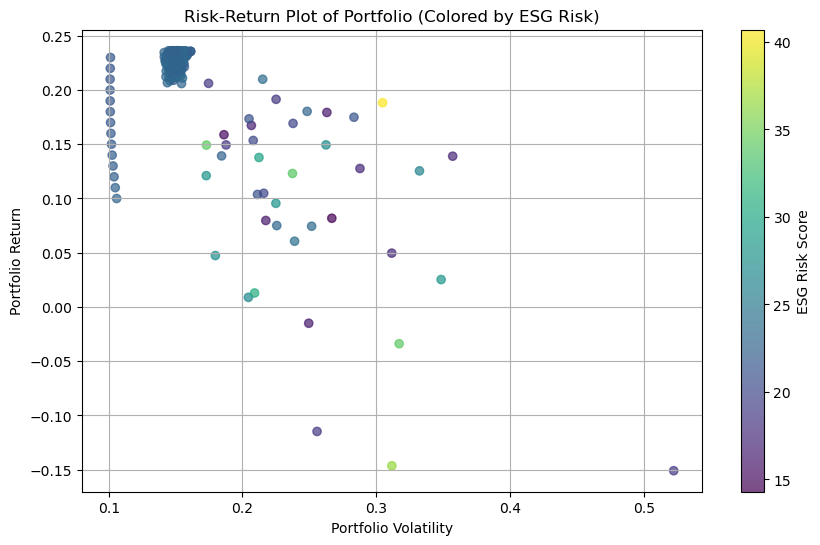

In [1605]:
volatility = pareto_front_2[:, 1]  # Assuming volatility is in the second column
returns = pareto_front_2[:, 0] 
esg_risk = pareto_front_2[:, 2]  # Assuming ESG Risk is in the first column

plt.figure(figsize=(10, 6))
sc = plt.scatter(volatility, returns, c=esg_risk, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="ESG Risk Score")  # Add color bar to show ESG Risk

# Add labels and title
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Return")
plt.title("Risk-Return Plot of Portfolio (Colored by ESG Risk)")

plt.grid(True)
plt.show()


In [960]:
def evaluate_all_1(population, cov_mat, expected_returns):
    cov_matrix = cov_mat
    weights = np.array([np.clip(ind, 0, 1) for ind in population])
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights_sum[weights_sum == 0] = 1  # Prevent division by zero
    weights = weights / weights_sum

    # Update normalized weights back to the individuals
    for ind, normalized_weights in zip(population, weights):
        for i in range(len(ind)):
            ind[i] = normalized_weights[i]

    # Calculate portfolio returns, volatility, and ESG scores for all individuals
    portfolio_returns = np.dot(weights, annualized_ret)
    portfolio_volatilities = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov_matrix, weights))
    portfolio_esg_scores = np.dot(weights, current_esg_risk_scores)

    # Combine results into a list of tuples (fitness values for DEAP)
    fitness_values = list(zip(-portfolio_returns, portfolio_volatilities, portfolio_esg_scores))

    return fitness_values

In [961]:
def recompute_fitness_1(population, cov_mat, expected_returns):
    # Identify individuals with invalid or empty fitness
    invalid_individuals = [ind for ind in population if not ind.fitness.valid or ind.fitness.values == ()]
    
    if invalid_individuals:
        #print(f"Recomputing fitness for {len(invalid_individuals)} individuals...")
        # Use evaluate_all for batch fitness computation
        invalid_fitness = evaluate_all_1(invalid_individuals, cov_mat, expected_returns)
        
        # Assign the computed fitness values back to the individuals
        for fit, ind in zip(invalid_fitness, invalid_individuals):
            ind.fitness.values = fit

In [1038]:
def calculate_min_variance_portfolio_with_constraints(cov_mat):
    """
    Calculate the weights of the minimum variance portfolio with constraints.
    Constraints:
    1. Weights sum to 1.
    2. Each weight is between 0 and 1.
    
    Parameters:
    cov_mat (numpy.ndarray): Covariance matrix of asset returns.

    Returns:
    numpy.ndarray: Weights of the minimum variance portfolio.
    """
    n = cov_mat.shape[0]  # Number of assets
    
    # Objective function: portfolio variance (w^T * cov_mat * w)
    def portfolio_variance(weights):
        return weights.T @ cov_mat @ weights
    
    # Constraints
    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}  # Sum of weights = 1
    ]
    
    # Bounds for weights: 0 <= w_i <= 1
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess (equal weights)
    initial_weights = np.ones(n) / n
    
    # Optimization
    result = minimize(
        portfolio_variance,
        initial_weights,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    # Check if the optimization was successful
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    return result.x

In [1078]:
def select_port(lookback, cov_mat, expected_returns):
    
    toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=1000, 
    hof=None  # Ensure this is passed dynamically
    )
    eff_front_std = initialize_optimized_population(cov_mat, expected_returns)
    population = toolbox.population(n=1000) + initialize_extreme_population() + eff_front_std
    hof = tools.HallOfFame(500)
    num_generations = 25

    for gen in range(num_generations):
        start_time = time.time()
        #print(f"Generation {gen} started...")
        
        # Generate offspring
        offspring = algorithms.varOr(population, toolbox, lambda_=2000, cxpb=0.75, mutpb=0.05)
        #print(f"Generated {len(offspring)} offspring.")
    
        normalize_population(population)
        normalize_population(offspring)
        
        # Evaluate fitness
        fits = evaluate_all_1(offspring, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, offspring):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
        
        
        combined = population + offspring
       
        # Calculate generation-specific distances
        min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
        #print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")
    
        for ind in combined:
            if not hasattr(ind, "fitness"):
                raise ValueError(f"Individual {ind} is missing the fitness attribute!")
    
        recompute_fitness_1(combined, cov_mat, expected_returns)
        
        population = [ind for ind in population if isinstance(ind, creator.Individual)]
     
        # Apply distance-based selection
        population = toolbox.select_with_distance(
        combined, 
        min_return_dist=min_return_dist, 
        min_volatility_dist=min_volatility_dist, 
        min_esg_dist=min_esg_dist, 
        k=1000, 
        hof=hof  # Pass dynamically here
        )
        
        #print(f"Selected next generation population of size {len(population)}.")
    
        #extreme_individuals = initialize_extreme_population()# Reinitialize extreme individuals
        #population.extend(extreme_individuals)
        population.extend(eff_front_std)  
    
        
        fits = evaluate_all_1(population, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
    
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, population):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
    
        
        hof.update(population)
        #print(f"Updated Hall of Fame with {len(hof)} solutions.")
        
        elapsed_time = time.time() - start_time
        #print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

    #print("Evolution completed!")

    pareto_front = np.array([ind.fitness.values for ind in hof])
    pareto_front[:,0] = -pareto_front[:,0]
    pareto_weights = np.array([list(ind) for ind in hof])
    print(pareto_front)
    # Filter the Pareto front based on the criteria
    filtered_pareto = [
        (fitness, weights) for fitness, weights in zip(pareto_front, pareto_weights)
        if fitness[2] < 25 and fitness[0] > 0.2  # ESG score < 25 and Return > 0.2
    ]
    # If no solutions meet the criteria, raise a warning or handle appropriately
    if not filtered_pareto:
        print("No solutions meet the specified criteria, using min variance portfolio")
        optimal_weights = calculate_min_variance_portfolio_with_constraints(cov_mat)
        
    else:
        # Extract variance (second element in fitness) for minimization
        filtered_variances = [fitness[1] for fitness, _ in filtered_pareto]
        
        # Find the index of the solution with the minimum variance
        min_variance_index = filtered_variances.index(min(filtered_variances))
        
        # Get the corresponding solution
        optimal_solution = filtered_pareto[min_variance_index]
        optimal_fitness, optimal_weights = optimal_solution
    return optimal_weights


In [1080]:
def backtest(lookback, returns_df, start_port_val):
    port_val = start_port_val
    start = lookback
    daily_changes = []
    daily_change = 0
    port_values = []
    for i in range(len(returns_df)-start):
        start_time = time.time()
        daily_changes.append(daily_change)
        port_values.append(port_val)
        if  i % 5 == 0:
            cov_mat = covariance_matrix(returns_df[i:i+start])
            expected_returns = compute_metrics(returns_df[i:i+start], tickers)["Annualized Mean"].values
            weights = select_port(lookback, cov_mat, expected_returns)
        else:
            weights = weights

        dollar_in_asset = []
        for j in range(len(weights)):
            asset = weights[j]*port_val
            dollar_in_asset.append(asset)
            
        x = np.zeros((len(weights),len(weights)))
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                if k == l:
                    x[k][l] = 1+np.array(returns_df[start+i:start+i+1])[0][k]
                else:
                    pass

        daily_change = (weights.T @ np.array(returns_df[start+i:start+i+1]).T)*port_val
        daily_change = daily_change[0]
        port_val = port_val+daily_change
        port_val = port_val
        new_weights = dollar_in_asset*x.diagonal()/(sum(dollar_in_asset)+daily_change)
        weights = new_weights
        elapsed_time = time.time() - start_time
        print(f"Day {i} completed in {elapsed_time:.2f} seconds., Current Portfolio Value: {port_val}")
        

    port_df = pd.DataFrame({'Port Values': port_values, 'Daily Dollar Changes': daily_changes})
    return port_df

In [1082]:
lookback = 20
returns_df = returns_df
start_port_val = 100
results = backtest(lookback, returns_df, start_port_val)
results

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 ...
 [ 0.2336479   0.21060249 23.04120242]
 [ 0.23365328  0.20630435 23.45968042]
 [ 0.23365459  0.19807928 23.7974228 ]]
Day 0 completed in 22.93 seconds., Current Portfolio Value: 100.90322984713201
Day 1 completed in 0.02 seconds., Current Portfolio Value: 100.57706080551425
Day 2 completed in 0.02 seconds., Current Portfolio Value: 100.39339116254382
Day 3 completed in 0.02 seconds., Current Portfolio Value: 100.94227068395976
Day 4 completed in 0.02 seconds., Current Portfolio Value: 100.88925995993458
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 24.45513768]
 [ 0.16484817  0.08344384 24.53130553]
 ...
 [ 0.23465483  0.18692165 22.58756713]
 [ 0.23465483  0.18692165 22.58756713]
 [ 0.23466306  0.18247641 23.0125794 ]]
Day 5 completed in 22.81 seconds., Current Portfolio Value: 100.17744991529277
Day 6 completed in 0.03 seconds., Current Portfoli

Port Values  Daily Dollar Changes
0     100.000000              0.000000
1     100.903230              0.903230
2     100.577061             -0.326169
3     100.393391             -0.183670
4     100.942271              0.548880
..           ...                   ...
443   137.823285              0.384166
444   139.396238              1.572954
445   141.372989              1.976751
446   140.663701             -0.709288
447   142.301826              1.638124

[448 rows x 2 columns]

In [1475]:
df_XLI =  yf.download("XLI", start = '2023-1-1', end = '2024-11-12')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [1476]:
normalized_bench = df_XLI[20:]/df_XLI.iloc[20]*100

In [1477]:
df_rf =  yf.download("^IRX", start = '2023-1-1', end = '2024-11-12')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [1478]:
daily_rf = df_rf[21:]/25200

In [1479]:
daily_rf

Ticker                         ^IRX
Date                               
2023-02-02 00:00:00+00:00  0.000179
2023-02-03 00:00:00+00:00  0.000179
2023-02-06 00:00:00+00:00  0.000180
2023-02-07 00:00:00+00:00  0.000181
2023-02-08 00:00:00+00:00  0.000182
...                             ...
2024-11-05 00:00:00+00:00  0.000176
2024-11-06 00:00:00+00:00  0.000176
2024-11-07 00:00:00+00:00  0.000175
2024-11-08 00:00:00+00:00  0.000176
2024-11-11 00:00:00+00:00  0.000175

[447 rows x 1 columns]

In [1480]:
normalized_bench

Ticker                            XLI
Date                                 
2023-02-01 00:00:00+00:00  100.000000
2023-02-02 00:00:00+00:00  100.779802
2023-02-03 00:00:00+00:00  100.253445
2023-02-06 00:00:00+00:00  100.009737
2023-02-07 00:00:00+00:00  100.321675
...                               ...
2024-11-05 00:00:00+00:00  136.344313
2024-11-06 00:00:00+00:00  141.683867
2024-11-07 00:00:00+00:00  140.832351
2024-11-08 00:00:00+00:00  142.345056
2024-11-11 00:00:00+00:00  143.447037

[448 rows x 1 columns]

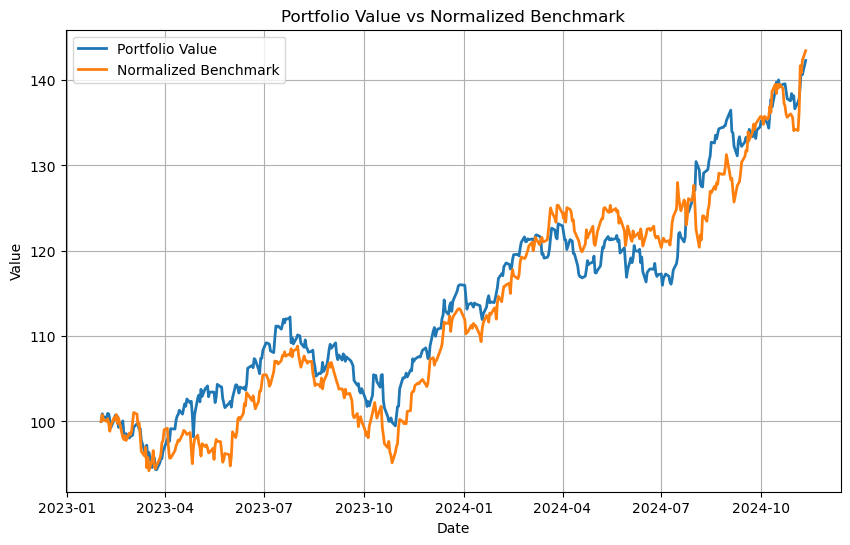

In [1481]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_bench.index, results["Port Values"], label="Portfolio Value", linewidth=2)   
plt.plot(normalized_bench.index, normalized_bench, label="Normalized Benchmark", linewidth=2)  # Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Portfolio Value vs Normalized Benchmark")
plt.legend()
plt.grid(True)
plt.show()

In [1497]:
def compute_alpha_beta(portfolio_returns, benchmark_returns, risk_free_rate=0.02):
    # Excess returns
    portfolio_excess = portfolio_returns - risk_free_rate.iloc[:,0]
    benchmark_excess = benchmark_returns - risk_free_rate.iloc[:,0]
    # Regression to compute beta and alpha
    beta, alpha, _, _, _ = linregress(benchmark_excess, portfolio_excess)
    
    return alpha, beta

In [1483]:
portfolio_returns = results['Port Values'].pct_change().dropna()
benchmark_returns = normalized_bench['XLI'].pct_change().dropna()

benchmark_returns = benchmark_returns.reset_index()
benchmark_returns.index = range(1, len(benchmark_returns) + 1)
benchmark_returns = benchmark_returns.drop(columns=["Date"])

daily_rf_reset = daily_rf.reset_index()
daily_rf_reset.index = range(1, len(daily_rf_reset) + 1)
risk_free_rate_aligned = daily_rf_reset.drop(columns=["Date"])


In [1499]:
compute_alpha_beta(portfolio_returns, benchmark_returns['XLI'], risk_free_rate_aligned)

(0.0006258793731896837, -0.010867592376728453)

In [1485]:
port_val = results["Port Values"]
high_watermark = port_val.cummax()

    # Calculate drawdown
drawdown = (port_val - high_watermark) / high_watermark

    # Calculate maximum drawdown
max_drawdown = drawdown.min()

    # Combine into a DataFrame
drawdown_df = pd.DataFrame({
    'Portfolio Value': port_val,
    'High Watermark': high_watermark,
    'Drawdown': drawdown
})

drawdown_df["Drawdown"].min()

-0.11371655889742668

In [1503]:
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate):
    """
    Calculate the Sharpe Ratio of a portfolio.

    Parameters:
    - portfolio_returns (pd.Series): Portfolio daily returns.
    - risk_free_rate (pd.Series or float): Daily risk-free rate (as a series or constant).

    Returns:
    - Sharpe Ratio (float)
    """
    # Ensure portfolio returns and risk-free rate are aligned
    portfolio_returns, risk_free_rate = portfolio_returns.align(risk_free_rate, join="inner")

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Compute Sharpe Ratio
    sharpe_ratio = excess_returns.mean() / portfolio_returns.std()
    return sharpe_ratio

# Example usage
sharpe = calculate_sharpe_ratio(portfolio_returns, risk_free_rate_aligned.iloc[:, 0])
sharpe_annualized = sharpe * (252 ** 0.5)
print(f"Annualized Sharpe Ratio: {sharpe_annualized}")


Annualized Sharpe Ratio: 1.2514491279358877


In [1525]:
def select_port_1(lookback, cov_mat, expected_returns, select_method, filter_vals):
    
    toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=1000, 
    hof=None  # Ensure this is passed dynamically
    )
    eff_front_std = initialize_optimized_population(cov_mat, expected_returns)
    population = toolbox.population(n=1000) + initialize_extreme_population() + eff_front_std
    hof = tools.HallOfFame(500)
    num_generations = 25

    for gen in range(num_generations):
        start_time = time.time()
        #print(f"Generation {gen} started...")
        
        # Generate offspring
        offspring = algorithms.varOr(population, toolbox, lambda_=2000, cxpb=0.75, mutpb=0.05)
        #print(f"Generated {len(offspring)} offspring.")
    
        normalize_population(population)
        normalize_population(offspring)
        
        # Evaluate fitness
        fits = evaluate_all_1(offspring, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, offspring):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
        
        
        combined = population + offspring
       
        # Calculate generation-specific distances
        min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
        #print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")
    
        for ind in combined:
            if not hasattr(ind, "fitness"):
                raise ValueError(f"Individual {ind} is missing the fitness attribute!")
    
        recompute_fitness_1(combined, cov_mat, expected_returns)
        
        population = [ind for ind in population if isinstance(ind, creator.Individual)]
     
        # Apply distance-based selection
        population = toolbox.select_with_distance(
        combined, 
        min_return_dist=min_return_dist, 
        min_volatility_dist=min_volatility_dist, 
        min_esg_dist=min_esg_dist, 
        k=1000, 
        hof=hof  # Pass dynamically here
        )
        
        #print(f"Selected next generation population of size {len(population)}.")
    
        #extreme_individuals = initialize_extreme_population()# Reinitialize extreme individuals
        #population.extend(extreme_individuals)
        population.extend(eff_front_std)  
    
        
        fits = evaluate_all_1(population, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
    
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, population):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
    
        
        hof.update(population)
        #print(f"Updated Hall of Fame with {len(hof)} solutions.")
        
        elapsed_time = time.time() - start_time
        #print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

    #print("Evolution completed!")

    pareto_front = np.array([ind.fitness.values for ind in hof])
    pareto_front[:,0] = -pareto_front[:,0]
    pareto_weights = np.array([list(ind) for ind in hof])
    print(pareto_front)
    # Filter the Pareto front based on the criteria
    filtered_pareto = [
        (fitness, weights) for fitness, weights in zip(pareto_front, pareto_weights)
        if fitness[2] < filter_vals[2] and fitness[0] > filter_vals[0] and fitness[1] < filter_vals[1] # ESG score < 25 and Return > 0.2
    ]
    # If no solutions meet the criteria, raise a warning or handle appropriately
    if not filtered_pareto:
        print("No solutions meet the specified criteria, using min variance portfolio")
        optimal_weights = calculate_min_variance_portfolio_with_constraints(cov_mat)
        
    else:
        # Extract variance (second element in fitness) for minimization
        filtered_variances = [fitness[1] for fitness, _ in filtered_pareto]
        filtered_returns = [fitness[0] for fitness, _ in filtered_pareto]
        filtered_esg_scores = [fitness[2] for fitness, _ in filtered_pareto]
        
        # Find the index of the solution with the minimum variance
        
        min_variance_index = filtered_variances.index(min(filtered_variances))
        max_return_index = filtered_returns.index(max(filtered_returns))
        min_esg_index = filtered_esg_scores.index(min(filtered_esg_scores))
        
        # Get the corresponding solution
        if select_method == 1 :
            optimal_solution = filtered_pareto[min_variance_index]
        elif select_method == 2:
            optimal_solution = filtered_pareto[max_return_index]
        elif select_method == 3:
            optimal_solution = filtered_pareto[min_esg_index]
        elif select_method == 4:
            select = np.random.rand()
            if select <= (1/3):
                optimal_solution = filtered_pareto[min_variance_index]
            elif select <= (2/3):
                optimal_solution = filtered_pareto[max_return_index]
            else:
                optimal_solution = filtered_pareto[min_esg_index]
        else: 
            print("Select a valid method for portfolio selection")
        optimal_fitness, optimal_weights = optimal_solution
    return optimal_weights

def backtest_1(lookback, returns_df, start_port_val, select_method, filter_vals):
    port_val = start_port_val
    start = lookback
    daily_changes = []
    daily_change = 0
    port_values = []
    for i in range(len(returns_df)-start):
        start_time = time.time()
        daily_changes.append(daily_change)
        port_values.append(port_val)
        if  i % 5 == 0:
            cov_mat = covariance_matrix(returns_df[i:i+start])
            expected_returns = compute_metrics(returns_df[i:i+start], tickers)["Annualized Mean"].values
            weights = select_port_1(lookback, cov_mat, expected_returns, select_method, filter_vals)
        else:
            weights = weights

        dollar_in_asset = []
        for j in range(len(weights)):
            asset = weights[j]*port_val
            dollar_in_asset.append(asset)
            
        x = np.zeros((len(weights),len(weights)))
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                if k == l:
                    x[k][l] = 1+np.array(returns_df[start+i:start+i+1])[0][k]
                else:
                    pass

        daily_change = (weights.T @ np.array(returns_df[start+i:start+i+1]).T)*port_val
        daily_change = daily_change[0]
        port_val = port_val+daily_change
        port_val = port_val
        new_weights = dollar_in_asset*x.diagonal()/(sum(dollar_in_asset)+daily_change)
        weights = new_weights
        elapsed_time = time.time() - start_time
        print(f"Day {i} completed in {elapsed_time:.2f} seconds., Current Portfolio Value: {port_val}")
        

    port_df = pd.DataFrame({'Port Values': port_values, 'Daily Dollar Changes': daily_changes})
    return port_df

In [1527]:
select_method_1 = 1
select_method_2 = 2
select_method_3 = 3
select_method_4 = 4
filter_vals = [ .2, 1, 25]

In [1528]:
lookback = 20
returns_df = returns_df
start_port_val = 100
results_1 = backtest_1(lookback, returns_df, start_port_val, select_method_1, filter_vals)
results_1

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 ...
 [ 0.23356475  0.20457101 23.06885217]
 [ 0.23356702  0.20769235 22.55649626]
 [ 0.23356702  0.20769235 22.55649626]]
Day 0 completed in 25.03 seconds., Current Portfolio Value: 100.90322984713201
Day 1 completed in 0.03 seconds., Current Portfolio Value: 100.57706080551425
Day 2 completed in 0.03 seconds., Current Portfolio Value: 100.39339116254382
Day 3 completed in 0.03 seconds., Current Portfolio Value: 100.94227068395976
Day 4 completed in 0.03 seconds., Current Portfolio Value: 100.88925995993458
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 24.45513768]
 [ 0.16484817  0.08344384 24.53130553]
 ...
 [ 0.23496225  0.18868908 22.51072511]
 [ 0.23509716  0.18744804 22.58569567]
 [ 0.23509716  0.18744804 22.58569567]]
Day 5 completed in 24.41 seconds., Current Portfolio Value: 100.17744991529277
Day 6 completed in 0.03 seconds., Current Portfoli

Port Values  Daily Dollar Changes
0     100.000000              0.000000
1     100.903230              0.903230
2     100.577061             -0.326169
3     100.393391             -0.183670
4     100.942271              0.548880
..           ...                   ...
443   135.960830              0.378975
444   137.512527              1.551698
445   139.462566              1.950038
446   138.772225             -0.690341
447   140.696761              1.924536

[448 rows x 2 columns]

In [1529]:
results_2 = backtest_1(lookback, returns_df, start_port_val, select_method_2, filter_vals)
results_2

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 ...
 [ 0.2341746   0.21321626 22.72161862]
 [ 0.23425494  0.2154462  22.83106354]
 [ 0.23425494  0.2154462  22.83106354]]
Day 0 completed in 69.13 seconds., Current Portfolio Value: 101.42765705576109
Day 1 completed in 0.09 seconds., Current Portfolio Value: 102.80350343474511
Day 2 completed in 0.07 seconds., Current Portfolio Value: 102.15148069513046
Day 3 completed in 0.07 seconds., Current Portfolio Value: 101.41729026621832
Day 4 completed in 0.07 seconds., Current Portfolio Value: 101.5379161842208
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 24.45513768]
 [ 0.16484817  0.08344384 24.53130553]
 ...
 [ 0.23276595  0.17904523 23.21902954]
 [ 0.23277243  0.17102594 23.1990848 ]
 [ 0.23277305  0.18618049 22.72240044]]
Day 5 completed in 70.44 seconds., Current Portfolio Value: 100.64337253401987
Day 6 completed in 0.08 seconds., Current Portfolio

Port Values  Daily Dollar Changes
0     100.000000              0.000000
1     101.427657              1.427657
2     102.803503              1.375846
3     102.151481             -0.652023
4     101.417290             -0.734190
..           ...                   ...
443   130.395089              0.119631
444   132.842533              2.447443
445   137.217882              4.375349
446   136.365144             -0.852738
447   137.750303              1.385159

[448 rows x 2 columns]

In [1531]:
results_3 = backtest_1(lookback, returns_df, start_port_val, select_method_3, filter_vals)
results_3

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 ...
 [ 0.23510727  0.20986863 22.73816198]
 [ 0.23510727  0.20986863 22.73816198]
 [ 0.23513051  0.20795222 22.76819951]]
Day 0 completed in 24.46 seconds., Current Portfolio Value: 101.39462951872667
Day 1 completed in 0.02 seconds., Current Portfolio Value: 102.9052184945813
Day 2 completed in 0.03 seconds., Current Portfolio Value: 102.33649306675446
Day 3 completed in 0.03 seconds., Current Portfolio Value: 101.65153816378592
Day 4 completed in 0.03 seconds., Current Portfolio Value: 101.8721448084546
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 24.45513768]
 [ 0.16484817  0.08344384 24.53130553]
 ...
 [ 0.23277883  0.18387391 21.91639619]
 [ 0.23291014  0.19025517 23.03763855]
 [ 0.23294971  0.17799532 22.5778481 ]]
Day 5 completed in 24.33 seconds., Current Portfolio Value: 101.07119216026729
Day 6 completed in 0.03 seconds., Current Portfolio 

Port Values  Daily Dollar Changes
0     100.000000              0.000000
1     101.394630              1.394630
2     102.905218              1.510589
3     102.336493             -0.568725
4     101.651538             -0.684955
..           ...                   ...
443   148.518133              0.242805
444   151.039740              2.521607
445   156.145805              5.106065
446   155.613179             -0.532627
447   157.178926              1.565747

[448 rows x 2 columns]

In [1532]:
results_4 = backtest_1(lookback, returns_df, start_port_val, select_method_4, filter_vals)
results_4

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 [ 0.18876529  0.11153003 23.93248653]
 ...
 [ 0.23391857  0.19585172 22.79188903]
 [ 0.23393108  0.19909015 22.55951909]
 [ 0.23394683  0.20846282 22.89374896]]
Day 0 completed in 24.99 seconds., Current Portfolio Value: 101.4935987873736
Day 1 completed in 0.02 seconds., Current Portfolio Value: 102.8441680800322
Day 2 completed in 0.02 seconds., Current Portfolio Value: 102.32908849321099
Day 3 completed in 0.03 seconds., Current Portfolio Value: 101.65247260207545
Day 4 completed in 0.03 seconds., Current Portfolio Value: 101.85058004934208
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 24.45513768]
 [ 0.16484817  0.08344384 24.53130553]
 ...
 [ 0.23304077  0.17017019 23.09438041]
 [ 0.23321905  0.18159857 22.71340939]
 [ 0.2332377   0.1808171  22.39738509]]
Day 5 completed in 25.68 seconds., Current Portfolio Value: 101.1209897877416
Day 6 completed in 0.03 seconds., Current Portfolio V

Port Values  Daily Dollar Changes
0     100.000000              0.000000
1     101.493599              1.493599
2     102.844168              1.350569
3     102.329088             -0.515080
4     101.652473             -0.676616
..           ...                   ...
443   131.977675              0.226765
444   134.346410              2.368735
445   139.189128              4.842718
446   138.444992             -0.744136
447   139.595826              1.150834

[448 rows x 2 columns]

In [1655]:
def select_port_2(lookback, cov_mat, expected_returns, filter_vals):
    



    
    toolbox.register(
    "select_with_distance", 
    select_with_distance_backup, 
    min_return_dist=initial_min_return_dist, 
    min_volatility_dist=initial_min_volatility_dist, 
    min_esg_dist=initial_min_esg_dist, 
    k=1000, 
    hof=None  # Ensure this is passed dynamically
    )
    eff_front_std = initialize_optimized_population(cov_mat, expected_returns)
    population = toolbox.population(n=1000) + initialize_extreme_population() + eff_front_std
    hof = tools.HallOfFame(500)
    num_generations = 25

    for gen in range(num_generations):
        start_time = time.time()
        #print(f"Generation {gen} started...")
        
        # Generate offspring
        offspring = algorithms.varOr(population, toolbox, lambda_=2000, cxpb=0.75, mutpb=0.05)
        #print(f"Generated {len(offspring)} offspring.")
    
        normalize_population(population)
        normalize_population(offspring)
        
        # Evaluate fitness
        fits = evaluate_all_1(offspring, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, offspring):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
        
        
        combined = population + offspring
       
        # Calculate generation-specific distances
        min_return_dist, min_volatility_dist, min_esg_dist = get_min_distances(gen, num_generations)
        #print(f"Generation {gen} - Distance thresholds: {min_return_dist}, {min_volatility_dist}, {min_esg_dist}")
    
        for ind in combined:
            if not hasattr(ind, "fitness"):
                raise ValueError(f"Individual {ind} is missing the fitness attribute!")
    
        recompute_fitness_1(combined, cov_mat, expected_returns)
        
        population = [ind for ind in population if isinstance(ind, creator.Individual)]
     
        # Apply distance-based selection
        population = toolbox.select_with_distance(
        combined, 
        min_return_dist=min_return_dist, 
        min_volatility_dist=min_volatility_dist, 
        min_esg_dist=min_esg_dist, 
        k=1000, 
        hof=hof  # Pass dynamically here
        )
        
        #print(f"Selected next generation population of size {len(population)}.")
    
        #extreme_individuals = initialize_extreme_population()# Reinitialize extreme individuals
        #population.extend(extreme_individuals)
        population.extend(eff_front_std)  
    
        
        fits = evaluate_all_1(population, cov_mat, expected_returns)
        #fits = toolbox.map(toolbox.evaluate, offspring)
    
        
        # Assign fitness values back to individuals
        for fit, ind in zip(fits, population):
            if fit != ():  # Ensure the fitness value is not empty
                ind.fitness.values = fit
            else:
                print(f"Empty fitness for individual: {ind}")
    
        
        hof.update(population)
        #print(f"Updated Hall of Fame with {len(hof)} solutions.")
        
        elapsed_time = time.time() - start_time
        #print(f"Generation {gen} completed in {elapsed_time:.2f} seconds.")
    

    #print("Evolution completed!")

    pareto_front = np.array([ind.fitness.values for ind in hof])
    pareto_front[:,0] = -pareto_front[:,0]
    pareto_weights = np.array([list(ind) for ind in hof])
    print(pareto_front)
    # Filter the Pareto front based on the criteria
    filtered_pareto = [
        (fitness, weights) for fitness, weights in zip(pareto_front, pareto_weights)
        if fitness[2] < filter_vals[2] and fitness[0] > filter_vals[0] and fitness[1] < filter_vals[1] # ESG score < 25 and Return > 0.2
    ]
    # If no solutions meet the criteria, raise a warning or handle appropriately
    if not filtered_pareto:
        print("No solutions meet the specified criteria, using min variance portfolio")
        optimal_weights = calculate_min_variance_portfolio_with_constraints(cov_mat)
        
    else:
        # Extract variance (second element in fitness) for minimization
        filtered_variances = [fitness[1] for fitness, _ in filtered_pareto]
        filtered_returns = [fitness[0] for fitness, _ in filtered_pareto]
        filtered_esg_scores = [fitness[2] for fitness, _ in filtered_pareto]
        
        # Find the index of the solution with the minimum variance
        
        min_variance_index = filtered_variances.index(min(filtered_variances))
        max_return_index = filtered_returns.index(max(filtered_returns))
        min_esg_index = filtered_esg_scores.index(min(filtered_esg_scores))
        
        optimal_solution_1 = filtered_pareto[min_variance_index]
        optimal_solution_2 = filtered_pareto[max_return_index]
        optimal_solution_3 = filtered_pareto[min_esg_index]
        select = np.random.rand()
        if select <= (1/3):
            optimal_solution_4 = filtered_pareto[min_variance_index]
        elif select <= (2/3):
            optimal_solution_4 = filtered_pareto[max_return_index]
        else:
            optimal_solution_4 = filtered_pareto[min_esg_index]
        optimal_fitness_1, optimal_weights_1 = optimal_solution_1
        optimal_fitness_2, optimal_weights_2 = optimal_solution_2
        optimal_fitness_3, optimal_weights_3 = optimal_solution_3
        optimal_fitness_4, optimal_weights_4 = optimal_solution_4
    return [optimal_weights_1, optimal_weights_2, optimal_weights_3, optimal_weights_4]

def backtest_2(lookback, returns_df, start_port_val, filter_vals, weights):
    if "FitnessMulti" in creator.__dict__:
        del creator.FitnessMulti
    if "Individual" in creator.__dict__:
        del creator.Individual
    w = weights
    creator.create("FitnessMulti", base.Fitness, weights=(w[0], w[1], w[2]))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)  # Random weights between 0 and 1
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(annualized_ret))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    #toolbox.register("evaluate", evaluate)  # Register the evaluation function
    toolbox.register("mate", tools.cxBlend, alpha=0.3)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=10, indpb=0.4)
    toolbox.register("select", tools.selNSGA2)
    
    pool = multiprocessing.Pool()
    toolbox.register("map", pool.map)
    
    initial_min_return_dist = 0.1
    initial_min_volatility_dist = 0.1
    initial_min_esg_dist = 1
    
    final_min_return_dist = 0.1
    final_min_volatility_dist = 0.1
    final_min_esg_dist = 1



    
    port_val = [start_port_val] * 4  # Initialize portfolio values for all 4 strategies
    start = lookback
    daily_changes = [[], [], [], []]  # For tracking daily dollar changes for all 4 weights
    daily_change = [0] * 4
    port_values = [[], [], [], []]
    for i in range(len(returns_df) - start):
        start_time = time.time()
        for w in range(4):  # Append current portfolio values for each strategy
            port_values[w].append(port_val[w])
            daily_changes[w].append(daily_change[w])
        if i % 5 == 0:
            cov_mat = covariance_matrix(returns_df[i:i+start])
            expected_returns = compute_metrics(returns_df[i:i+start], tickers)["Annualized Mean"].values
            weights_all = select_port_2(lookback, cov_mat, expected_returns, filter_vals)
        else:
            # Use the last weights for all 4 strategies
            weights_all = weights_all

        dollar_in_asset = [[w[j] * port_val[idx] for j in range(len(w))] for idx, w in enumerate(weights_all)]

        # Update portfolios for all weights
        for w_idx in range(4):
            x = np.zeros((len(weights_all[w_idx]), len(weights_all[w_idx])))
            for k in range(x.shape[0]):
                x[k][k] = 1 + np.array(returns_df[start+i:start+i+1])[0][k]
        
            daily_change[w_idx] = (weights_all[w_idx] @ np.array(returns_df[start+i:start+i+1]).T) * port_val[w_idx]
            daily_change[w_idx] = daily_change[w_idx][0]
            port_val[w_idx] = port_val[w_idx] + daily_change[w_idx]
        
            # Normalize weights to ensure they sum to 1
            weights_all[w_idx] = weights_all[w_idx] / sum(weights_all[w_idx])
        '''       
        for w_idx in range(4):
            x = np.zeros((len(weights_all[w_idx]), len(weights_all[w_idx])))
            for k in range(x.shape[0]):
                x[k][k] = 1 + np.array(returns_df[start+i:start+i+1])[0][k]
            
            daily_change[w_idx] = (weights_all[w_idx] @ np.array(returns_df[start+i:start+i+1]).T) * port_val[w_idx]
            daily_change[w_idx] = daily_change[w_idx][0]
            port_val[w_idx] = port_val[w_idx] + daily_change[w_idx]
'''
        elapsed_time = time.time() - start_time
        print(f"Day {i} completed in {elapsed_time:.2f} seconds, Current Portfolio Values: {port_val}")

    # Construct a DataFrame with all results
    port_df = pd.DataFrame({
        'Min Variance': port_values[0],
        'Max Return': port_values[1],
        'Min ESG': port_values[2],
        'Random': port_values[3],
    })

    return port_df    
       

In [1712]:
lookback = 20
lookback_1 = 40
lookback_2 = 60
weights = [1,-1,-1]
filter_vals = [ .15, 1, 30]

In [1714]:
results_5 = backtest_2(lookback_1, returns_df, start_port_val, filter_vals,weights)

[[ 0.18965421  0.09493105 24.17831468]
 [ 0.19242085  0.09467042 24.17718803]
 [ 0.19583537  0.09442417 24.1937347 ]
 ...
 [ 0.22817135  0.18315219 23.62401816]
 [ 0.22829365  0.18124263 22.03969229]
 [ 0.22836148  0.17686491 22.95216716]]
Day 0 completed in 35.52 seconds, Current Portfolio Values: [100.55943869325918, 100.36235991907353, 101.26768871083655, 100.55943869325918]
Day 1 completed in 0.12 seconds, Current Portfolio Values: [101.01042469028705, 101.78611204416576, 102.57038352321277, 101.01042469028705]
Day 2 completed in 0.13 seconds, Current Portfolio Values: [101.13842883072223, 101.23729445786395, 102.16016885787228, 101.13842883072223]
Day 3 completed in 0.10 seconds, Current Portfolio Values: [100.64204882407854, 101.9908722409139, 101.06550507416327, 100.64204882407854]
Day 4 completed in 0.13 seconds, Current Portfolio Values: [100.86651064689049, 102.17809891970894, 101.36925725042751, 100.86651064689049]
[[ 0.21707438  0.08648346 24.20537607]
 [ 0.21854959  0.0862

In [1715]:
results_6 = backtest_2(lookback_2, returns_df, start_port_val, filter_vals, weights)

[[ 0.17457865  0.10911215 23.9418446 ]
 [ 0.17457865  0.10911215 23.9418446 ]
 [ 0.17734252  0.10887081 23.91324091]
 ...
 [ 0.23085321  0.19361513 23.36322983]
 [ 0.23088938  0.1880709  23.00026992]
 [ 0.23092813  0.19201099 23.10967554]]
Day 0 completed in 37.66 seconds, Current Portfolio Values: [100.32407284722078, 100.06438955313236, 100.30179646756656, 100.32407284722078]
Day 1 completed in 0.10 seconds, Current Portfolio Values: [101.16494881399782, 102.08065358578429, 101.83360424857473, 101.16494881399782]
Day 2 completed in 0.10 seconds, Current Portfolio Values: [102.50200516390994, 103.26394474200102, 101.6077959116878, 102.50200516390994]
Day 3 completed in 0.11 seconds, Current Portfolio Values: [102.23636159195071, 101.39689370977118, 99.12961242666108, 102.23636159195071]
Day 4 completed in 0.08 seconds, Current Portfolio Values: [102.21272818961909, 100.4374828639465, 97.76960836852898, 102.21272818961909]
[[ 0.16037734  0.10680559 23.1457476 ]
 [ 0.16141057  0.1065111

In [1716]:
results_5.tail()

Min Variance  Max Return     Min ESG      Random
423    140.059020  189.638555  124.959102  164.536679
424    141.565085  195.735195  127.573007  166.305954
425    145.074536  211.052843  132.729482  170.428740
426    145.303077  206.023250  132.211919  166.367259
427    148.339286  210.515635  133.488171  169.994935

In [1717]:
results_6.tail()

Min Variance  Max Return     Min ESG      Random
403    127.792664  132.241347  114.010530  157.661777
404    129.227389  136.359720  115.874666  159.431842
405    132.000701  146.390177  119.511641  162.853364
406    132.308465  142.929692  119.374622  163.233062
407    134.990778  146.052709  123.343318  166.542314

In [1718]:
results_1.tail()

Port Values  Daily Dollar Changes
443   135.960830              0.378975
444   137.512527              1.551698
445   139.462566              1.950038
446   138.772225             -0.690341
447   140.696761              1.924536

In [1719]:
results_2.tail()

Port Values  Daily Dollar Changes
443   130.395089              0.119631
444   132.842533              2.447443
445   137.217882              4.375349
446   136.365144             -0.852738
447   137.750303              1.385159

In [1720]:
results_3.tail()

Port Values  Daily Dollar Changes
443   148.518133              0.242805
444   151.039740              2.521607
445   156.145805              5.106065
446   155.613179             -0.532627
447   157.178926              1.565747

In [1721]:
results_4.tail()

Port Values  Daily Dollar Changes
443   131.977675              0.226765
444   134.346410              2.368735
445   139.189128              4.842718
446   138.444992             -0.744136
447   139.595826              1.150834

In [1722]:
daily_rf_1 = df_rf[41:]/25200
normalized_bench_1 = df_XLI[40:]/df_XLI.iloc[40]*100
daily_rf_2 = df_rf[61:]/25200
normalized_bench_2 = df_XLI[60:]/df_XLI.iloc[60]*100

In [1723]:
weights_1 = [30,-1,-1]
weights_2 = [1,-30,-1]
weights_3 = [1,-1,-5] 
filter_vals = [0,1,100]

In [1724]:
# weight of 30 on the return
results_7 = backtest_2(lookback, returns_df, start_port_val, filter_vals, weights_1)

[[ 0.19764665  0.20063702 22.63373852]
 [ 0.19764665  0.20063702 22.63373852]
 [ 0.19812571  0.19320699 22.34847097]
 ...
 [ 0.23605095  0.2090727  22.46476112]
 [ 0.23607019  0.20142113 23.10829019]
 [ 0.23607548  0.21354107 21.63623965]]
Day 0 completed in 55.49 seconds, Current Portfolio Values: [101.16800620251416, 101.54761378241388, 101.41869496532289, 101.41869496532289]
Day 1 completed in 0.11 seconds, Current Portfolio Values: [102.2952600624211, 102.87701324589798, 102.84671428761816, 102.84671428761816]
Day 2 completed in 0.10 seconds, Current Portfolio Values: [101.74785213396439, 102.21904495892007, 102.33163969607577, 102.33163969607577]
Day 3 completed in 0.09 seconds, Current Portfolio Values: [101.26374663107478, 101.49022227453479, 101.60562950109096, 101.60562950109096]
Day 4 completed in 0.09 seconds, Current Portfolio Values: [101.69226446306149, 101.9272440571166, 101.89719140700443, 101.89719140700443]
[[ 0.20567951  0.19352231 23.01503987]
 [ 0.2064382   0.18041

In [1728]:
#weight of -30 on variance
results_8 = backtest_2(lookback, returns_df, start_port_val, filter_vals, weights_2)

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 [ 0.18876529  0.11153003 23.93248653]
 ...
 [ 0.50357852  0.31322691 27.34849562]
 [ 0.50357852  0.31322691 27.34849562]
 [ 0.50357852  0.31322691 27.34849562]]
Day 0 completed in 174.75 seconds, Current Portfolio Values: [100.88446881154577, 102.55629884873221, 100.87147865091785, 102.55629884873221]
Day 1 completed in 0.34 seconds, Current Portfolio Values: [100.438060734529, 105.811518271423, 100.60022804135303, 105.811518271423]
Day 2 completed in 0.33 seconds, Current Portfolio Values: [100.19884685009724, 103.65391632546395, 100.39808605608386, 103.65391632546395]
Day 3 completed in 0.32 seconds, Current Portfolio Values: [100.67288117491411, 103.34232165979627, 101.05229762436822, 103.34232165979627]
Day 4 completed in 0.36 seconds, Current Portfolio Values: [100.26175627518197, 103.26497671069954, 101.43409879268573, 103.26497671069954]
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171

In [1729]:
#weight of -5 on ESG score
results_9 = backtest_2(lookback, returns_df, start_port_val, filter_vals, weights_3)

[[ 0.1849134   0.11191096 23.87397713]
 [ 0.1849134   0.11191096 23.87397713]
 [ 0.18661353  0.11172011 23.90445175]
 ...
 [ 0.50357852  0.31322691 27.34849562]
 [ 0.50357852  0.31322691 27.34849562]
 [ 0.50357852  0.31322691 27.34849562]]
Day 0 completed in 55.86 seconds, Current Portfolio Values: [100.88446881154577, 102.55629884873221, 100.87147865091785, 100.88446881154577]
Day 1 completed in 0.12 seconds, Current Portfolio Values: [100.438060734529, 105.811518271423, 100.60022804135303, 100.438060734529]
Day 2 completed in 0.14 seconds, Current Portfolio Values: [100.19884685009724, 103.65391632546395, 100.39808605608386, 100.19884685009724]
Day 3 completed in 0.15 seconds, Current Portfolio Values: [100.67288117491411, 103.34232165979627, 101.05229762436822, 100.67288117491411]
Day 4 completed in 0.10 seconds, Current Portfolio Values: [100.26175627518197, 103.26497671069954, 101.43409879268573, 100.26175627518197]
[[ 0.16274543  0.08381518 24.43028471]
 [ 0.16441873  0.08362171 

In [1732]:
results_7.tail()

Min Variance  Max Return     Min ESG      Random
443    127.859592  133.541455  131.426742  132.206625
444    130.105835  135.948444  133.949918  134.744774
445    134.430677  140.492195  138.640216  139.462903
446    134.047801  139.675542  137.300277  139.065695
447    135.736101  141.717050  138.611130  140.817194

In [1734]:
results_8.tail()

Min Variance  Max Return     Min ESG      Random
443    134.095326  207.026530  160.718408  162.087400
444    135.542099  214.329856  163.658239  167.805397
445    137.251329  233.631546  168.938684  182.917280
446    137.801164  230.542240  169.695594  183.736820
447    137.842195  234.231572  169.866884  183.922283

In [1736]:
results_9.tail()

Min Variance  Max Return     Min ESG      Random
443    134.095326  207.541785  170.487720  173.820199
444    135.542099  214.715885  172.327135  175.695570
445    137.251329  233.864875  174.500236  177.911147
446    137.801164  230.690608  175.282064  178.623867
447    137.842195  234.367998  175.458993  178.677053

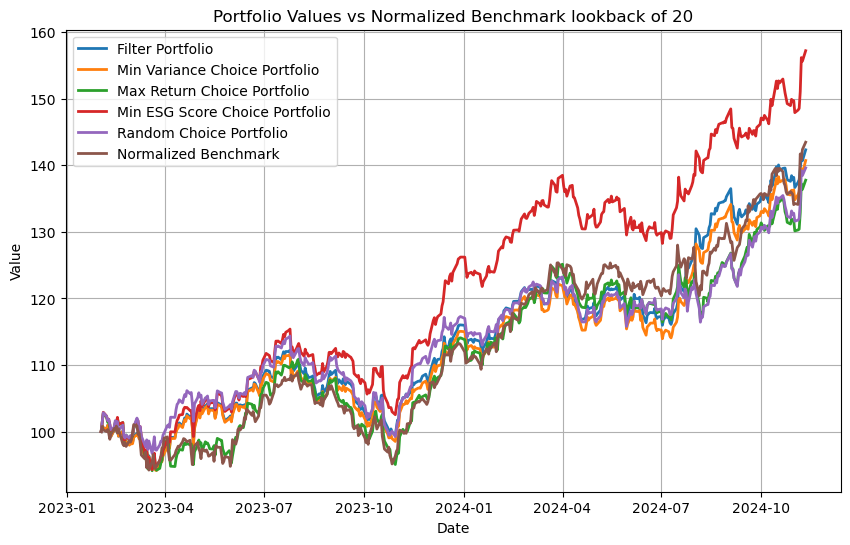

In [1738]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_bench.index, results["Port Values"], label="Filter Portfolio", linewidth=2)   
plt.plot(normalized_bench.index, results_1["Port Values"], label="Min Variance Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench.index, results_2["Port Values"], label="Max Return Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench.index, results_3["Port Values"], label="Min ESG Score Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench.index, results_4["Port Values"], label="Random Choice Portfolio", linewidth=2)  
plt.plot(normalized_bench.index, normalized_bench, label="Normalized Benchmark", linewidth=2)  # Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Portfolio Values vs Normalized Benchmark lookback of 20")
plt.legend()
plt.grid(True)
plt.show()

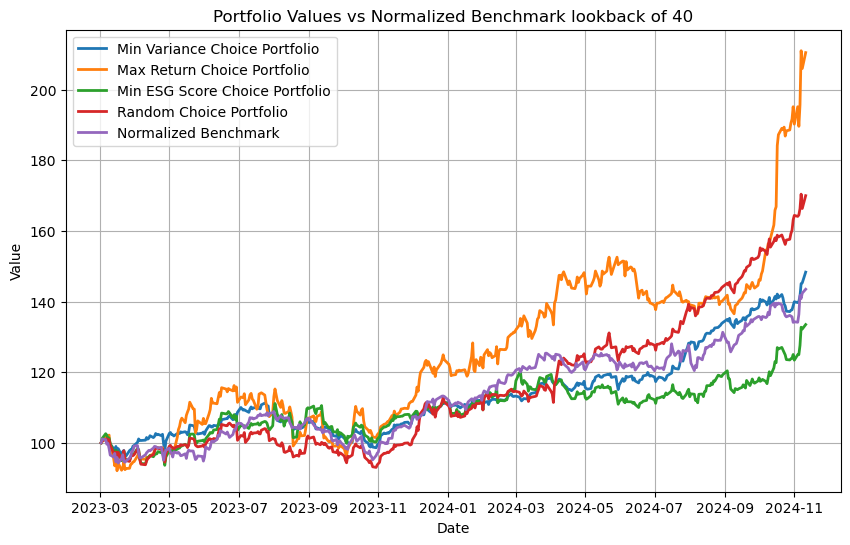

In [1740]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_bench_1.index, results_5["Min Variance"], label="Min Variance Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_1.index, results_5["Max Return"], label="Max Return Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_1.index, results_5["Min ESG"], label="Min ESG Score Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_1.index, results_5["Random"], label="Random Choice Portfolio", linewidth=2)  
plt.plot(normalized_bench_1.index, normalized_bench_1, label="Normalized Benchmark", linewidth=2)  # Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Portfolio Values vs Normalized Benchmark lookback of 40")
plt.legend()
plt.grid(True)
plt.show()

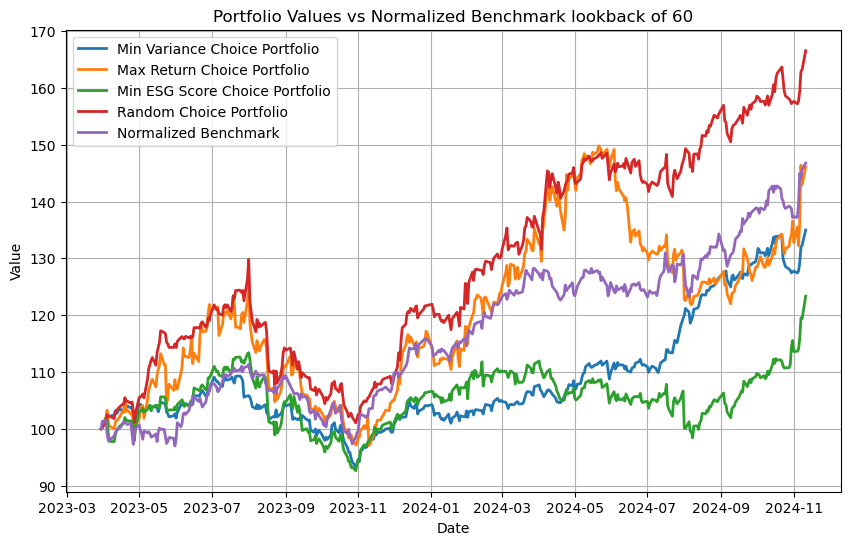

In [1742]:
plt.figure(figsize=(10, 6))
plt.plot(normalized_bench_2.index, results_6["Min Variance"], label="Min Variance Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_2.index, results_6["Max Return"], label="Max Return Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_2.index, results_6["Min ESG"], label="Min ESG Score Choice Portfolio", linewidth=2)   
plt.plot(normalized_bench_2.index, results_6["Random"], label="Random Choice Portfolio", linewidth=2)  
plt.plot(normalized_bench_2.index, normalized_bench_2, label="Normalized Benchmark", linewidth=2)  # Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Portfolio Values vs Normalized Benchmark lookback of 60")
plt.legend()
plt.grid(True)
plt.show()

In [1744]:
def compute_alpha_beta(portfolio_returns, benchmark_returns, risk_free_rate=0.02):
    # Excess returns
    portfolio_excess = portfolio_returns - risk_free_rate.iloc[:,0]
    benchmark_excess = benchmark_returns - risk_free_rate.iloc[:,0]
    # Regression to compute beta and alpha
    beta, alpha, _, _, _ = linregress(benchmark_excess, portfolio_excess)
    
    return alpha, beta

In [1745]:
portfolio_returns = results_3['Port Values'].pct_change().dropna()
benchmark_returns = normalized_bench['XLI'].pct_change().dropna()

benchmark_returns = benchmark_returns.reset_index()
benchmark_returns.index = range(1, len(benchmark_returns) + 1)
benchmark_returns = benchmark_returns.drop(columns=["Date"])

daily_rf_reset = daily_rf.reset_index()
daily_rf_reset.index = range(1, len(daily_rf_reset) + 1)
risk_free_rate_aligned = daily_rf_reset.drop(columns=["Date"])


In [1746]:
compute_alpha_beta(portfolio_returns, benchmark_returns['XLI'], risk_free_rate_aligned)

(0.0008419875313452851, 0.008384222968234569)

In [1747]:
port_val = results_3["Port Values"]
high_watermark = port_val.cummax()

    # Calculate drawdown
drawdown = (port_val - high_watermark) / high_watermark

    # Calculate maximum drawdown
max_drawdown = drawdown.min()

    # Combine into a DataFrame
drawdown_df = pd.DataFrame({
    'Portfolio Value': port_val,
    'High Watermark': high_watermark,
    'Drawdown': drawdown
})

drawdown_df["Drawdown"].min()

-0.11139695285389932

In [1748]:
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate):
    """
    Calculate the Sharpe Ratio of a portfolio.

    Parameters:
    - portfolio_returns (pd.Series): Portfolio daily returns.
    - risk_free_rate (pd.Series or float): Daily risk-free rate (as a series or constant).

    Returns:
    - Sharpe Ratio (float)
    """
    # Ensure portfolio returns and risk-free rate are aligned
    portfolio_returns, risk_free_rate = portfolio_returns.align(risk_free_rate, join="inner")

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Compute Sharpe Ratio
    sharpe_ratio = excess_returns.mean() / portfolio_returns.std()
    return sharpe_ratio

# Example usage
sharpe = calculate_sharpe_ratio(portfolio_returns, risk_free_rate_aligned.iloc[:, 0])
sharpe_annualized = sharpe * (252 ** 0.5)
print(f"Annualized Sharpe Ratio: {sharpe_annualized}")


Annualized Sharpe Ratio: 1.569830261600888


In [1754]:
portfolio_returns = results_5['Max Return'].pct_change().dropna()
benchmark_returns = normalized_bench_1['XLI'].pct_change().dropna()

benchmark_returns = benchmark_returns.reset_index()
benchmark_returns.index = range(1, len(benchmark_returns) + 1)
benchmark_returns = benchmark_returns.drop(columns=["Date"])

daily_rf_reset = daily_rf_1.reset_index()
daily_rf_reset.index = range(1, len(daily_rf_reset) + 1)
risk_free_rate_aligned = daily_rf_reset.drop(columns=["Date"])


In [1755]:
port_val = results_5["Max Return"]
high_watermark = port_val.cummax()

    # Calculate drawdown
drawdown = (port_val - high_watermark) / high_watermark

    # Calculate maximum drawdown
max_drawdown = drawdown.min()

    # Combine into a DataFrame
drawdown_df = pd.DataFrame({
    'Portfolio Value': port_val,
    'High Watermark': high_watermark,
    'Drawdown': drawdown
})

drawdown_df["Drawdown"].min()

-0.17084769448030346

In [1758]:
compute_alpha_beta(portfolio_returns, benchmark_returns['XLI'], risk_free_rate_aligned)

(0.0017263146524724392, -0.07151686038492851)

In [1760]:
sharpe = calculate_sharpe_ratio(portfolio_returns, risk_free_rate_aligned.iloc[:, 0])
sharpe_annualized = sharpe * (252 ** 0.5)
print(f"Annualized Sharpe Ratio: {sharpe_annualized}")

Annualized Sharpe Ratio: 1.6164263292800058


In [1762]:
portfolio_returns = results_6['Random'].pct_change().dropna()
benchmark_returns = normalized_bench_2['XLI'].pct_change().dropna()

benchmark_returns = benchmark_returns.reset_index()
benchmark_returns.index = range(1, len(benchmark_returns) + 1)
benchmark_returns = benchmark_returns.drop(columns=["Date"])

daily_rf_reset = daily_rf_2.reset_index()
daily_rf_reset.index = range(1, len(daily_rf_reset) + 1)
risk_free_rate_aligned = daily_rf_reset.drop(columns=["Date"])


In [1764]:
port_val = results_5["Random"]
high_watermark = port_val.cummax()

    # Calculate drawdown
drawdown = (port_val - high_watermark) / high_watermark

    # Calculate maximum drawdown
max_drawdown = drawdown.min()

    # Combine into a DataFrame
drawdown_df = pd.DataFrame({
    'Portfolio Value': port_val,
    'High Watermark': high_watermark,
    'Drawdown': drawdown
})

drawdown_df["Drawdown"].min()

-0.11883054640194443

In [1766]:
compute_alpha_beta(portfolio_returns, benchmark_returns['XLI'], risk_free_rate_aligned)

(0.0011361139671075965, -0.02742279007444146)

In [1768]:
sharpe = calculate_sharpe_ratio(portfolio_returns, risk_free_rate_aligned.iloc[:, 0])
sharpe_annualized = sharpe * (252 ** 0.5)
print(f"Annualized Sharpe Ratio: {sharpe_annualized}")

Annualized Sharpe Ratio: 1.563613917228423


In [1772]:
annualized_ret

GE      0.678135
CAT     0.293006
RTX     0.137796
UBER    0.560454
ETN     0.479192
          ...   
ALLE    0.169238
GNRC    0.373176
PAYC   -0.150974
AOS     0.149424
HII    -0.033861
Length: 75, dtype: float64

In [1774]:
annualized_vol

GE      0.273924
CAT     0.277305
RTX     0.212359
UBER    0.376888
ETN     0.276374
          ...   
ALLE    0.237826
GNRC    0.481832
PAYC    0.522411
AOS     0.262466
HII     0.317148
Length: 75, dtype: float64

In [1784]:
covariance_matrix(returns_df)

array([[ 0.0750344 ,  0.02788922,  0.00822908, ...,  0.02911713,
         0.01845729,  0.01635416],
       [ 0.02788922,  0.07689793,  0.01369633, ...,  0.02623608,
         0.03190939,  0.02297208],
       [ 0.00822908,  0.01369633,  0.04509644, ...,  0.01075786,
         0.00974642,  0.0179556 ],
       ...,
       [ 0.02911713,  0.02623608,  0.01075786, ...,  0.27291355,
         0.02016179, -0.00821075],
       [ 0.01845729,  0.03190939,  0.00974642, ...,  0.02016179,
         0.06888843,  0.01868173],
       [ 0.01635416,  0.02297208,  0.0179556 , ..., -0.00821075,
         0.01868173,  0.10058271]])

In [1780]:
np.array(current_esg_risk_scores)

array([32.7, 28.3, 29.6, 20.4, 21. , 20. , 27.1, 15.1, 28.1, 36.5, 16.3,
       18.8, 14.8, 26.7, 18.8, 34.1, 38.2, 17. , 22.6, 22.8, 26.6, 40.7,
       21.1, 19. , 16.2, 23.3, 24.5, 15.7, 16.1, 16. , 20.1, 15.7, 18.8,
       36.6, 25. , 16.7, 23.6, 21.1, 30.5, 15.9, 18.5, 10.6, 30.4, 18.8,
       16.3, 22.7, 21.3, 17.5, 22.9, 31.6, 24.5, 17.3, 27.9, 15.5, 17.9,
       26.7, 28.3, 27.6, 23.5, 22.3, 22. , 30.6, 16.2, 33.8, 14.3, 24.1,
       18.6, 26.2, 17.4, 17.3, 19.8, 21.9, 18.9, 26.8, 34.2])

In [1778]:
returns_df

GE       CAT       RTX      UBER       ETN  \
Date                                                                          
2023-01-03 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2023-01-04 00:00:00+00:00  0.056573  0.010328  0.000298  0.021456  0.006760   
2023-01-05 00:00:00+00:00  0.015408 -0.004485  0.000397 -0.013992 -0.010253   
2023-01-06 00:00:00+00:00  0.009076  0.035086  0.015541  0.032727  0.024506   
2023-01-09 00:00:00+00:00  0.010096 -0.009042 -0.028310  0.037179 -0.001367   
...                             ...       ...       ...       ...       ...   
2024-11-05 00:00:00+00:00  0.020172  0.018029  0.008271  0.012212  0.018995   
2024-11-06 00:00:00+00:00  0.030900  0.083798  0.021699  0.002828  0.062317   
2024-11-07 00:00:00+00:00 -0.010623 -0.021017 -0.012497 -0.016680  0.003835   
2024-11-08 00:00:00+00:00  0.032781 -0.037031  0.028488 -0.015017  0.016804   
2024-11-11 00:00:00+00:00 -0.001354  0.008026  0.008142 -0.005428  0.014297   

                                UNP       HON       ADP       LMT        BA  \
Date                                                                          
2023-01-03 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2023-01-04 00:00:00+00:00  0.007965 -0.020079  0.004702 -0.002159  0.041356   
2023-01-05 00:00:00+00:00 -0.029882 -0.026877 -0.021804  0.001196  0.006607   
2023-01-06 00:00:00+00:00  0.043033  0.027971  0.027567 -0.008061  0.038331   
2023-01-09 00:00:00+00:00 -0.002597  0.001901 -0.002710 -0.030574 -0.021017   
...                             ...       ...       ...       ...       ...   
2024-11-05 00:00:00+00:00  0.017077  0.005957  0.004544  0.006698 -0.026597   
2024-11-06 00:00:00+00:00  0.060637  0.035847  0.046960  0.009230 -0.025759   
2024-11-07 00:00:00+00:00 -0.024154  0.005070 -0.001082  0.000036  0.025627   
2024-11-08 00:00:00+00:00 -0.004421  0.009108 -0.000394  0.022788  0.004626   
2024-11-11 00:00:00+00:00  0.001903  0.025860  0.006705  0.010607 -0.018095   

                           ...      NDSN       ROL       SWK      CHRW  \
Date                       ...                                           
2023-01-03 00:00:00+00:00  ...       NaN       NaN       NaN       NaN   
2023-01-04 00:00:00+00:00  ... -0.001177  0.010614  0.031141  0.005743   
2023-01-05 00:00:00+00:00  ... -0.034271 -0.017202  0.000509 -0.008739   
2023-01-06 00:00:00+00:00  ...  0.025909  0.006041  0.030433  0.036006   
2023-01-09 00:00:00+00:00  ...  0.022935  0.000000  0.013356  0.000536   
...                        ...       ...       ...       ...       ...   
2024-11-05 00:00:00+00:00  ...  0.023237  0.014314  0.023861  0.021968   
2024-11-06 00:00:00+00:00  ...  0.042421  0.001441 -0.049499  0.014100   
2024-11-07 00:00:00+00:00  ... -0.014440  0.008601 -0.001631  0.013904   
2024-11-08 00:00:00+00:00  ...  0.003333  0.022980 -0.018787  0.006005   
2024-11-11 00:00:00+00:00  ... -0.000880  0.013853  0.000333  0.004320   

                                DAY      ALLE      GNRC      PAYC       AOS  \
Date                                                                          
2023-01-03 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2023-01-04 00:00:00+00:00  0.023912  0.014198  0.042184 -0.002399  0.029104   
2023-01-05 00:00:00+00:00 -0.052747 -0.013734 -0.036469 -0.031012 -0.021327   
2023-01-06 00:00:00+00:00  0.018878  0.033493  0.024923 -0.027424  0.034104   
2023-01-09 00:00:00+00:00  0.031010  0.007600  0.038839  0.020510  0.000813   
...                             ...       ...       ...       ...       ...   
2024-11-05 00:00:00+00:00  0.023074  0.009986  0.062820  0.032933  0.010327   
2024-11-06 00:00:00+00:00  0.047950  0.000213  0.009252  0.055838  0.003813   
2024-11-07 00:00:00+00:00 -0.003961  0.012551  0.017342 -0.017021 -0.002365   
2024-11-08 00:00:00+00:00  0.006305  0.007470  0.014041  0.006843 -0.015508   
2024-11-11 00:00:00+00:00 -0.018408 -0.002437  0.029966 -0.004601 

In [3]:
from itertools import product

In [ ]:
esg_scores = np.array(current_esg_risk_scores)
cov_matrix = covariance_matrix(returns_df)
initial_weights = np.ones(len(esg_scores))/len(esg_scores)  # Initial weights
annualized_returns = np.array(annualized_ret)
alpha_values = np.arange(0.1, 1.0, 0.1)  # Alpha between 0.1 and 0.9 in 0.1 increments
lambda_values = [0.25, 0.5, 1, 2, 5, 10, 20]  # Specified lambda values
target_returns = np.linspace(0, 0.7, 500)
# Softmax normalization
softmax_esg = np.exp(esg_scores) / np.sum(np.exp(esg_scores))

# Objective function
def objective(w, alpha, lambda_):
    variance = w.T @ cov_matrix @ w
    penalty = lambda_ * np.dot(w, softmax_esg)
    return (1 - alpha) * variance + alpha * penalty

# Constraints
def get_constraints(target_return):
    return [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Sum of weights = 1
        {'type': 'eq', 'fun': lambda w: np.dot(w, annualized_returns) - target_return}  # Target return
    ]
bounds = [(0, 1) for _ in range(len(esg_scores))]  # No short-selling

results = []
total_start_time = time.time()
# Loop over all combinations of alpha, lambda, and target return
for alpha, lambda_, target_return in product(alpha_values, lambda_values, target_returns):
    start_time = time.time()
    constraints = get_constraints(target_return)
    result = minimize(objective, initial_weights, args=(alpha, lambda_), bounds=bounds, constraints=constraints)

    end_time = time.time()  # End timer for this optimization
    duration = end_time - start_time
    print(f"Iteration Time: {duration:.2f} seconds")
    if result.success:
        weights = result.x
        variance = weights.T @ cov_matrix @ weights
        esg_risk = np.dot(weights, esg_scores)
        results.append({
            'Alpha': alpha,
            'Lambda': lambda_,
            'Target Return': target_return,
            'Portfolio Variance': variance,
            'Portfolio ESG Risk': esg_risk
        })
total_end_time = time.time()
total_duration = total_end_time - total_start_time
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"Total Optimization Time: {total_duration:.2f} seconds")
# Optimization
#result = minimize(objective, weights, bounds=bounds, constraints=constraints)
#optimal_weights = result.x

Iteration Time: 0.10 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.13 seconds
Iteration Time: 0.12 seconds
Iteration Time: 0.12 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.10 seconds
Iteration Time: 0.12 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.10 seconds
Iteration Time: 0.13 seconds
Iteration Time: 0.11 seconds
Iteration Time: 0.13 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.07 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.06 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.09 seconds
Iteration Time: 0.08 seconds
Iteration Time: 0.10 seconds
Iteration Time: 0.10 seconds
Iteration Time: 0.10 seconds
Iteration Time: 0.09 seconds
Iteration Time

In [ ]:
results_df

In [1854]:
print(optimal_weights@annualized_returns,optimal_weights@esg_scores,optimal_weights.T@cov_matrix@optimal_weights)

0.4999999999595362 23.08259411489076 0.023268383335948297


In [1856]:
max(annualized_returns)

0.7004643102403219

In [ ]:
def select_port_2(lookback, cov_mat, expected_returns, ):
    
    return [optimal_weights_1, optimal_weights_2, optimal_weights_3, optimal_weights_4]


def backtest_3(lookback, returns_df, start_port_val, filter_vals, weights):
    port_val = [start_port_val] * 4  # Initialize portfolio values for all 4 strategies
    start = lookback
    daily_changes = [[], [], [], []]  # For tracking daily dollar changes for all 4 weights
    daily_change = [0] * 4
    port_values = [[], [], [], []]
    for i in range(len(returns_df) - start):
        start_time = time.time()
        for w in range(4):  # Append current portfolio values for each strategy
            port_values[w].append(port_val[w])
            daily_changes[w].append(daily_change[w])
        if i % 5 == 0:
            cov_mat = covariance_matrix(returns_df[i:i+start])
            expected_returns = compute_metrics(returns_df[i:i+start], tickers)["Annualized Mean"].values
            weights_all = select_port_3(lookback, cov_mat, expected_returns, filter_vals)
        else:
            # Use the last weights for all 4 strategies
            weights_all = weights_all

        dollar_in_asset = [[w[j] * port_val[idx] for j in range(len(w))] for idx, w in enumerate(weights_all)]

        # Update portfolios for all weights
        for w_idx in range(4):
            x = np.zeros((len(weights_all[w_idx]), len(weights_all[w_idx])))
            for k in range(x.shape[0]):
                x[k][k] = 1 + np.array(returns_df[start+i:start+i+1])[0][k]
        
            daily_change[w_idx] = (weights_all[w_idx] @ np.array(returns_df[start+i:start+i+1]).T) * port_val[w_idx]
            daily_change[w_idx] = daily_change[w_idx][0]
            port_val[w_idx] = port_val[w_idx] + daily_change[w_idx]
        
            # Normalize weights to ensure they sum to 1
            weights_all[w_idx] = weights_all[w_idx] / sum(weights_all[w_idx])
        '''       
        for w_idx in range(4):
            x = np.zeros((len(weights_all[w_idx]), len(weights_all[w_idx])))
            for k in range(x.shape[0]):
                x[k][k] = 1 + np.array(returns_df[start+i:start+i+1])[0][k]
            
            daily_change[w_idx] = (weights_all[w_idx] @ np.array(returns_df[start+i:start+i+1]).T) * port_val[w_idx]
            daily_change[w_idx] = daily_change[w_idx][0]
            port_val[w_idx] = port_val[w_idx] + daily_change[w_idx]
'''
        elapsed_time = time.time() - start_time
        print(f"Day {i} completed in {elapsed_time:.2f} seconds, Current Portfolio Values: {port_val}")

    # Construct a DataFrame with all results
    port_df = pd.DataFrame({
        'Min Variance': port_values[0],
        'Max Return': port_values[1],
        'Min ESG': port_values[2],
        'Random': port_values[3],
    })

    return port_df